# Классификация «уходящих» клиентов оператора связи

## Задача <a class = "tocSkip">

Построить для оператора связи модель, которая будет классифицировать клиентов в качестве «уходящих» и демонстировать качество прогноза `AUC-ROC` не ниже `0.85`. Дополнительная метрика — `Accuracy`.

На основе предсказаний модели планируется предлагать таким «уходящим» клиентам промокоды и специальные условия.

## Предоставленные данные <a class = "tocSkip">

Полученные из разных источников персональные данные о некоторых клиентах и информация об их тарифах и договорах в форме четырех файлов:

- `contract.csv` — информация о клиентских договорах (актуальна на 1 февраля 2020 года);
- `personal.csv` — персональные данные клиентов;
- `internet.csv` — информация об оказываемых клиентам интернет-услугах;
- `phone.csv` — информация об оказываемых клиентам услугах телефонии.

Во всех файлах столбец `customerID` содержит уникальный код клиента.

## План работы <a class = "tocSkip">

Мы планируем, что работа над задачей будет включать шесть этапов:

1. загрузка и первичное изучение данных;
2. подготовка данных для исследовательского анализа;
3. исследовательский анализ данных;
4. подготовка к обучению моделей;
5. обучение моделей; и
6. тестирование моделей.

## Подготовка к работе <a class = "tocSkip">

Загрузим необходимые библиотеки:

In [1]:
# загрузка библиотек
!pip install -q phik
!pip install -q optuna
!pip install -q catboost

In [2]:
# загрузка библиотек

# общие, работа с файлами
import os
import six
import joblib
import warnings
import numpy as np

# исследовательский анализ данных
import phik
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# подготовка данных
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold, cross_val_score

# модели
from sklearn.svm import SVC
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, VotingClassifier

# оценка моделей
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve

# оптимизация гиперпараметров
import optuna
from optuna.samplers import TPESampler
from optuna.exceptions import ExperimentalWarning

# отбор признаков
from sklearn.inspection import permutation_importance

Настроим параметры отображения таблиц, графиков и предупреждений:

In [3]:
# настройка отображения таблиц
pd.set_option('display.max_colwidth', None)

# настройка отображения графиков
plt.style.use('fivethirtyeight')

# настройка отображения предупреждений
optuna.logging.set_verbosity(optuna.logging.WARNING) 
warnings.filterwarnings('ignore', category = UserWarning)
warnings.filterwarnings('ignore', category = FutureWarning)
warnings.filterwarnings('ignore', category = ExperimentalWarning)

Зафиксируем параметр `random_state` для всего ноутбука:

In [4]:
# фиксирование параметра random_state
random_state = 12345

## Загрузка и первичное изучение данных

In [5]:
# подключение google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# указание пути к данным
path = '/content/drive/MyDrive/yandex-practicum-data-science-course-projects/telecom-churn-prediction'

In [7]:
# чтение файлов с данными
contract = pd.read_csv(os.path.join(path, 'contract.csv'), true_values = ['Yes'], false_values = ['No'])
internet = pd.read_csv(os.path.join(path, 'internet.csv'), true_values = ['Yes'], false_values = ['No'])
personal = pd.read_csv(os.path.join(path, 'personal.csv'), true_values = ['Yes'], false_values = ['No'])
phone    = pd.read_csv(os.path.join(path, 'phone.csv'), true_values = ['Yes'], false_values = ['No'])

In [8]:
# сохранение датасетов в словарь
datasets_dict = {'contract' : contract,
                 'personal' : personal,
                 'internet' : internet,
                 'phone'    : phone}

По каждому датасету изучим пять первых объектов:

In [9]:
# вывод на экран первых пяти строк каждого датасета
for dataset_name, dataset in datasets_dict.items():
    print(dataset_name)
    display(dataset.head())
    print()
    print()

contract


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,True,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,False,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,True,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,False,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,True,Electronic check,70.70,151.65




personal


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,True,False
1,5575-GNVDE,Male,0,False,False
2,3668-QPYBK,Male,0,False,False
3,7795-CFOCW,Male,0,False,False
4,9237-HQITU,Female,0,False,False




internet


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,False,True,False,False,False,False
1,5575-GNVDE,DSL,True,False,True,False,False,False
2,3668-QPYBK,DSL,True,True,False,False,False,False
3,7795-CFOCW,DSL,True,False,True,True,False,False
4,9237-HQITU,Fiber optic,False,False,False,False,False,False




phone


,customerID,MultipleLines
0,5575-GNVDE,False
1,3668-QPYBK,False
2,9237-HQITU,False
3,9305-CDSKC,True
4,1452-KIOVK,True


- значения признака `customerID` первых пяти объектов датасетов `contract`, `personal` и `internet` совпадают и отличаются от значений датасета `phone` (возможно не все клиенты пользуются услугами телефонии);
- ни один из предоставленных файлов не содержит целевого признака, но его можно создать на основе признака `EndDate` датасета `contract` (значение `'No'` означает, что клиент продолжает пользоваться услугами оператора);
- датасеты содержат 19 признаков (без учета признака `customerID`), включая:
    - 2 числовых;
    - 16 категориальных;
    - 1 календарный.

Проверим, что:
- датасеты `contract` и `personal` содержат информацию об одних и тех же клиентах;
- датасеты `internet` и `phone` содержат информацию только о клиентах, сведения о которых есть в датасетах `contract` и `personal`.

In [10]:
print('Датасеты contract и personal содержат информацию об одних и тех же клиентах:', 
      (contract.customerID == personal.customerID).all())

print('Датасеты internet и phone содержат информацию только о клиентах, сведения о которых есть в датасете contract:',
      (set(internet.customerID).issubset(contract.customerID) and
       set(phone.customerID).issubset(contract.customerID)))

Датасеты contract и personal содержат информацию об одних и тех же клиентах: True
Датасеты internet и phone содержат информацию только о клиентах, сведения о которых есть в датасете contract: True


Все датасеты содержат информацию об одних и тех же клиентах, поэтому мы можем объединить их.

Изучим общую информацию о датасетах:

In [11]:
# по каждому датасету вывод на экран общей информации
for dataset_name, dataset in datasets_dict.items():
    print(f'{dataset_name}\n')
    dataset.info()
    print()
    print()

contract

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   bool   
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: bool(1), float64(1), object(6)
memory usage: 392.2+ KB


personal

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner      

Мы видим, что:
- датасеты не содержат явных пропусков;
- датасеты `contract` и `personal` содержат 7043 объекта, датасеты `internet` и `phone` — 5517 и 6361 объект соответственно;
- не все клиенты одновременно пользуются интернет-услугами и услугами телефонии;
- датасет `contract`:
    - целесообразно изменить тип данных признаков `BeginDate` и `EndDate` на `datetime` (предварительно обработав значения `'No'` в `EndDate`)
    - целесообразно изменить тип данных признака `TotalCharges` на `float` (предварительно проверив, содержит ли он нечисловые значения).

Проверим, содержит ли признак `TotalCharges` датасета `contract` нечисловые значения:

In [12]:
# проверка, содерджит ли признак TotalCharges датасета contract нечисловые значения
try: pd.to_numeric(contract.TotalCharges, errors='raise')
except ValueError as err: print(err)

Unable to parse string " " at position 488


Мы видим, что объект с индексом 488 содержит неявный пропуск `' '` в качестве значения признака. Изучим аналогичные объекты:

In [13]:
# вывод на экран объектов датасета contract с нечисловыми значениями признака TotalCharges 
display(contract[contract.TotalCharges == ' '])

# вывод количества объектов датасета contract с нечисловыми значениями признака TotalCharges 
print(f'Количество объектов с пропусками в TotalCharges: {len(contract[contract.TotalCharges == " "])}')

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,No,Two year,True,Bank transfer (automatic),52.55,
753,3115-CZMZD,2020-02-01,No,Two year,False,Mailed check,20.25,
936,5709-LVOEQ,2020-02-01,No,Two year,False,Mailed check,80.85,
1082,4367-NUYAO,2020-02-01,No,Two year,False,Mailed check,25.75,
1340,1371-DWPAZ,2020-02-01,No,Two year,False,Credit card (automatic),56.05,
3331,7644-OMVMY,2020-02-01,No,Two year,False,Mailed check,19.85,
3826,3213-VVOLG,2020-02-01,No,Two year,False,Mailed check,25.35,
4380,2520-SGTTA,2020-02-01,No,Two year,False,Mailed check,20.00,
5218,2923-ARZLG,2020-02-01,No,One year,True,Mailed check,19.70,
6670,4075-WKNIU,2020-02-01,No,Two year,False,Mailed check,73.35,


Количество объектов с пропусками в TotalCharges: 11


Мы видим, что все клиенты, о которых нет информации об общих расходах, заключили контракт 1 февраля 2020 года (в дату окончания периода, за который предоставлена информация о клиентских договорах). Разумно предположить, что для таких клиентов значения признака `TotalCharges` равны значениям признака `MonthlyCharges` (они являются клиентами один месяц).

Проверим, содержат ли датасеты дубликаты:

In [14]:
# по каждому датасету вывод на экран количества дубликатов
for dataset_name, dataset in datasets_dict.items():
    print(f'Количество дубликатов в датасете {dataset_name}: {dataset.duplicated().sum()}')

Количество дубликатов в датасете contract: 0
Количество дубликатов в датасете personal: 0
Количество дубликатов в датасете internet: 0
Количество дубликатов в датасете phone: 0


### Выводы

На данном этапе мы загрузили данные и провели их первичное изучение.

По его итогам мы установили:

**Общие выводы**

- датасеты `contract` и `personal` содержат 7043 объекта, датасеты `internet` и `phone` — 5517 и 6361 объект соответственно;
- не все клиенты одновременно пользуются интернет-услугами и услугами телефонии;
- датасеты не содержат явных пропусков и дубликатов;
- датасеты содержат информацию об одних и тех же клиентах;
- датасеты содержат 19 признаков (без учета признака `customerID`), включая:
    - 2 числовых;
    - 16 категориальных;
    - 1 календарный.

**Предобработка данных**

Необходимо/целесообразно:

- объединить датасеты;
- создать целевой признак `Churn` на основе признака `EndDate` датасета `contract`;
- устранить неявные пропуски в значениях признака `TotalCharges` датасета `contract` (заполнив их значениями признака `MonthlyCharges`);
- изменить типы данных признаков: 
    - `BeginDate` и `EndDate` датасета `contract` на `datetime`;
    - `TotalCharges` датасета `contract` на `float`.

## Подготовка данных для исследовательского анализа

В ходе подготовки данных для исследовательского анализа:

- объединим датасеты;
- изменим типы данных отдельных признаков;
- устраним пропуски;
- создадим новые признаки.

### Объединение датасетов

In [15]:
# по каждому датасету установка customerID в качестве индекса
for dataset in datasets_dict.values():
    dataset.set_index('customerID', inplace = True)

# объединение датасетов
all_data = contract.join([personal, internet, phone])

# вывод на экран количеста объектов и признаков объединенного датасета
print('all_data shape:', all_data.shape)

# вывод на экран первых пяти строк объединенного датасета
all_data.head()

all_data shape: (7043, 19)


,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
customerID,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,True,Electronic check,29.85,29.85,Female,0,True,False,DSL,False,True,False,False,False,False,NaN
5575-GNVDE,2017-04-01,No,One year,False,Mailed check,56.95,1889.5,Male,0,False,False,DSL,True,False,True,False,False,False,False
3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,True,Mailed check,53.85,108.15,Male,0,False,False,DSL,True,True,False,False,False,False,False
7795-CFOCW,2016-05-01,No,One year,False,Bank transfer (automatic),42.30,1840.75,Male,0,False,False,DSL,True,False,True,True,False,False,NaN
9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,True,Electronic check,70.70,151.65,Female,0,False,False,Fiber optic,False,False,False,False,False,False,False


### Изменение типов данных

Изменим типы данных признаков:
- `TotalCharge` — на `float`;
- `BeginDate` и `EndDate` — на `datetime`.

In [16]:
# изменение типов данных 
all_data['TotalCharges'] = pd.to_numeric(all_data['TotalCharges'], errors='coerce')
all_data[['BeginDate', 'EndDate']] = all_data[['BeginDate', 'EndDate']].apply(pd.to_datetime, errors='coerce')

# проверка изменения типов данных
all_data[['TotalCharges', 'BeginDate', 'EndDate']].dtypes

TotalCharges           float64
BeginDate       datetime64[ns]
EndDate         datetime64[ns]
dtype: object

### Устранение пропусков

В результате объединения датасетов и изменения типов данных возникли пропуски:

In [17]:
# вывод на экран количества пропусков
all_data.isna().sum().to_frame(name = 'Количество пропусков')

,Количество пропусков
BeginDate,0
EndDate,5174
Type,0
PaperlessBilling,0
PaymentMethod,0
MonthlyCharges,0
TotalCharges,11
gender,0
SeniorCitizen,0
Partner,0


Перед их устранением создадим признак-индикатор используемых услуг `Services` и для этого создадим функцию `define_services`:

In [18]:
# создание функции define_services
def define_services(df):
    '''
    Функция определяет услуги оператора, которыми пользуется клиент:
    - 'phone' (если клиент пользуется только услугами телефонии);
    - 'internet' (если клиент пользуется только интернет-услугами);
    - 'internet and phone'(если клиент одновременно пользуется услугами телефонии и 
      интернет-услугами).

    Параметры:
    - df — датасет с информацией об клиентах оператора.
    '''
 
    if np.isnan(df['StreamingMovies']):
        return 'phone'
    elif np.isnan(df['MultipleLines']):
        return 'internet'
    else:
        return 'internet and phone'

In [19]:
# создание признака Services
all_data['Services'] = all_data.apply(define_services, axis=1)

# проверка создания признака
all_data.head()

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,Services
customerID,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,NaT,Month-to-month,True,Electronic check,29.85,29.85,Female,0,True,False,DSL,False,True,False,False,False,False,NaN,internet
5575-GNVDE,2017-04-01,NaT,One year,False,Mailed check,56.95,1889.50,Male,0,False,False,DSL,True,False,True,False,False,False,False,internet and phone
3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,True,Mailed check,53.85,108.15,Male,0,False,False,DSL,True,True,False,False,False,False,False,internet and phone
7795-CFOCW,2016-05-01,NaT,One year,False,Bank transfer (automatic),42.30,1840.75,Male,0,False,False,DSL,True,False,True,True,False,False,NaN,internet
9237-HQITU,2019-09-01,2019-11-01,Month-to-month,True,Electronic check,70.70,151.65,Female,0,False,False,Fiber optic,False,False,False,False,False,False,False,internet and phone


Заполним пропуски в значениях:

- признака `EndDate` — значением `'2020-02-01 00:00:00'` (последней датой, на которую доступны данные о клиентских договорах);
- признака `TotalCharges` — значениями признака `MonthlyCharges`;
- признака `InternetService` — значением `not using internet`;
- остальных признаков — значением `False`.

In [20]:
# заполнение пропусков
all_data.EndDate.fillna('2020-02-01 00:00:00', inplace = True)
all_data.TotalCharges.fillna(all_data.MonthlyCharges, inplace = True)
all_data.InternetService.fillna('not using internet', inplace = True)
all_data.fillna(False, inplace = True)

# проверка заполнения пропусков
all_data.isna().sum().to_frame(name = 'Количество пропусков')

,Количество пропусков
BeginDate,0
EndDate,0
Type,0
PaperlessBilling,0
PaymentMethod,0
MonthlyCharges,0
TotalCharges,0
gender,0
SeniorCitizen,0
Partner,0


### Создание новых признаков

Создадим следующие новые признаки:

- `Churn` — продолжает ли клиент пользоваться услугами оператора (целевой признак);
- `ContractDurationDays` — количество дней пользования услугами;
- `NumAddServices` — количество дополнительных услуг, котормыми пользуется клиент.

In [21]:
# создание новых признаков
all_data['Churn'] = all_data.EndDate != all_data.EndDate.max()
all_data['ContractDurationDays'] = (all_data.EndDate.dt.to_period('D').astype(int) - 
                                    all_data.BeginDate.dt.to_period('D').astype(int))

additional_services = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
                'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines']

all_data['NumAddServices'] = all_data[additional_services].sum(axis = 1)

# проверка создания новых признаков
all_data.head()

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,...,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,Services,Churn,ContractDurationDays,NumAddServices
customerID,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,True,Electronic check,29.85,29.85,Female,0,True,...,True,False,False,False,False,False,internet,False,31,1
5575-GNVDE,2017-04-01,2020-02-01,One year,False,Mailed check,56.95,1889.50,Male,0,False,...,False,True,False,False,False,False,internet and phone,False,1036,2
3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,True,Mailed check,53.85,108.15,Male,0,False,...,True,False,False,False,False,False,internet and phone,True,61,2
7795-CFOCW,2016-05-01,2020-02-01,One year,False,Bank transfer (automatic),42.30,1840.75,Male,0,False,...,False,True,True,False,False,False,internet,False,1371,3
9237-HQITU,2019-09-01,2019-11-01,Month-to-month,True,Electronic check,70.70,151.65,Female,0,False,...,False,False,False,False,False,False,internet and phone,True,61,0


### Выводы

В ходе подготовки данных для исследовательского анализа мы:

- объединили датасеты;
- изменили типы данных признаков:

    - `TotalCharge` — на `float`;
    - `BeginDate` и `EndDate` — на `datetime`;
    
- заполнили пропуски в значениях:

    - признака `EndDate` — значением `'2020-02-01 00:00:00'` (последней датой, на которую доступны данные о клиентских договорах);
    - признака `TotalCharges` — значениями признака `MonthlyCharges`;
    - признака `InternetService` — значением `not using internet`;
    - остальных признаков — значением `False`;

- создали следующие новые признаки:

    - `Services` — услуги, которыми пользуется клиент (услуги телефонии, интернет-услуги или все вместе);
    - `Churn` — продолжает ли клиент пользоваться услугами оператора (целевой признак);
    - `ContractDurationDays` — количество дней пользования услугами;
    - `NumAddServices` — количество дополнительных услуг, котормыми пользуется клиент.

Теперь мы можем приступить к исследовательскому анализу данных.

## Исследовательский анализ данных

В ходе исследовательского анализа данных:

- проанализируем соотношение классов;
- сравним классы по различным признакам;
- составим портрет типичного ушедшего пользователя;
- изучим корреляцию между признаками.

### Соотношение классов

Изучим соотношение классов:

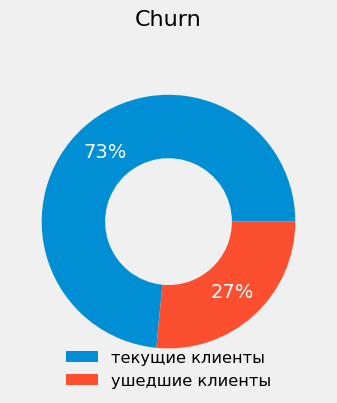

In [22]:
# вывод на экран круговой диаграммы соотношения классов
fig, ax = plt.subplots(figsize = (4,4))

ax.pie(x           = all_data.Churn.value_counts(), 
       autopct     = '%.0f%%', 
       textprops   = {'color' : 'w'},
       wedgeprops  = {'width' : 0.5},
       pctdistance = 0.75)

fig.legend(labels         = ['текущие клиенты', 'ушедшие клиенты'], 
           loc            = 'lower center', 
           frameon        = False,
           fontsize       = 'small')

fig.suptitle('Churn', fontsize = 16)

plt.tight_layout()
plt.show()

Классы несбалансированы — ушедшие пользователи составляют чуть больше четверти всей выборки. 

Основаня целевая метрика — `AUC-ROC` — не чувствительна к дисбалансу классов, дополнительная — `Accuracy` — чувствительна, поэтому во время тестирования моделей стоит дополнительно изучить матрицы ошибок.

### Категориальные признаки

Для удобства анализа создадим функцию `plot_pie_feature`:

In [23]:
# создание функции plot_pie_feature
def plot_pie_feature(data, feature):
    '''
    Функция выводит на экран круговую диаграмму значений признака по каждому классу.
    
    Параметры:
    - data — данные для построения диаграммы;
    - feature — признак, по которому сравниваются классы.
    '''

    fig, ax = plt.subplots(ncols = 2, figsize=(8,4))

    ax = ax.flatten()

    for i, churn in enumerate([False, True]):
        
        x = data[all_data.Churn == churn][feature].value_counts().sort_index()
        
        ax[i].pie(x           = x, 
                  autopct     = '%.0f%%', 
                  textprops   = {'color' : 'w'},
                  wedgeprops  = {'width' : 0.5},
                  pctdistance = 0.75)

    ax[0].set_title('текущие клиенты', fontsize = 14)
    ax[1].set_title('ушедшие клиенты', fontsize = 14)

    fig.legend(labels         = x.index, 
               loc            = 'lower center', 
               frameon        = False,
               fontsize       = 'small')

    fig.suptitle(feature, fontsize = 16)

    plt.tight_layout()
    plt.show()

#### Персональные данные

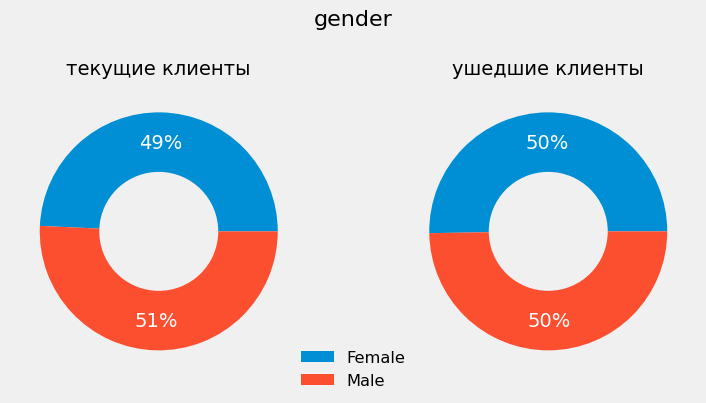

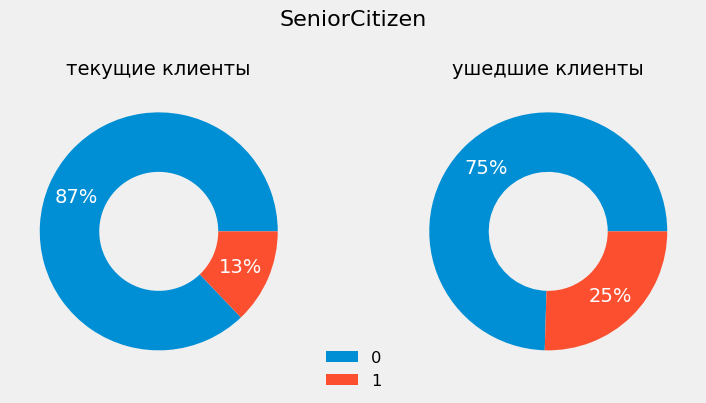

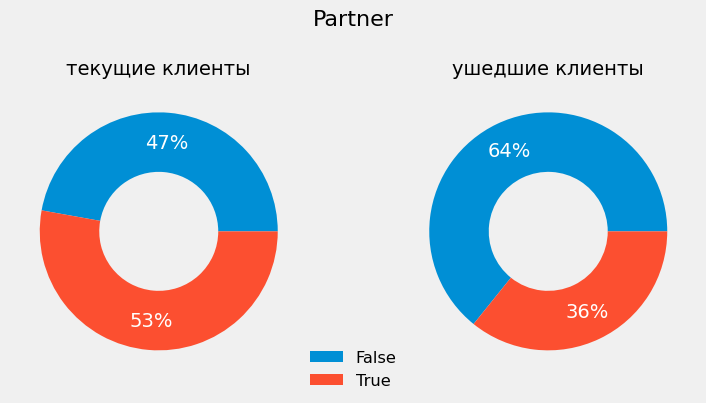

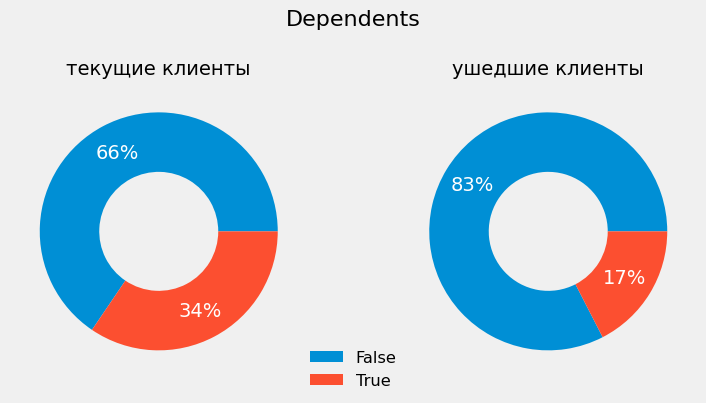

In [24]:
# создание списка с названиями категориальных признаков - персональных данных
cat_features_personal = ['gender', 'SeniorCitizen', 'Partner', 'Dependents']

# применение функции plot_pie_feature
for feature in cat_features_personal:
    plot_pie_feature(all_data, feature)

Среди ушедших клиентов:

- вдвое больше пенсионеров (25% против 13%); 
- на треть меньше имеющих партнеров (36% против 53%);
- вдвое меньше имеющих иждивенцев (17% против 34%).

В обоих классах примерно одинаковое разделение по полу (данный признак может быть малоинформативен).

#### Используемые услуги

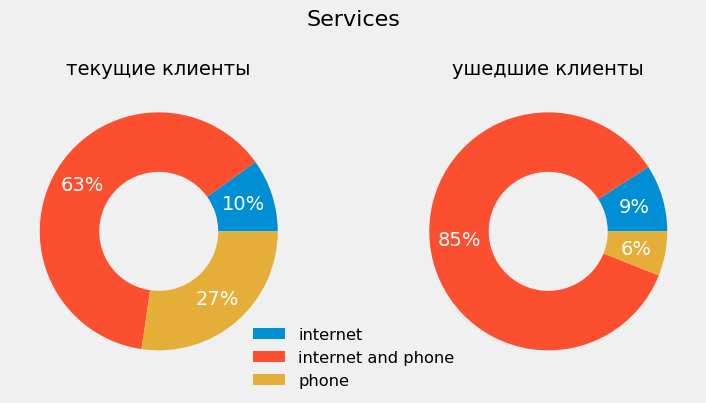

In [25]:
# применение функции plot_pie_feature
plot_pie_feature(all_data, 'Services')

Среди ушедших клиентов:

- на треть больше одновременно пользующихся услугами телефонии и интернет-услугами (85% против 63%); 
- значительно меньше пользующихся только услугами телефонии (6% против 27%).

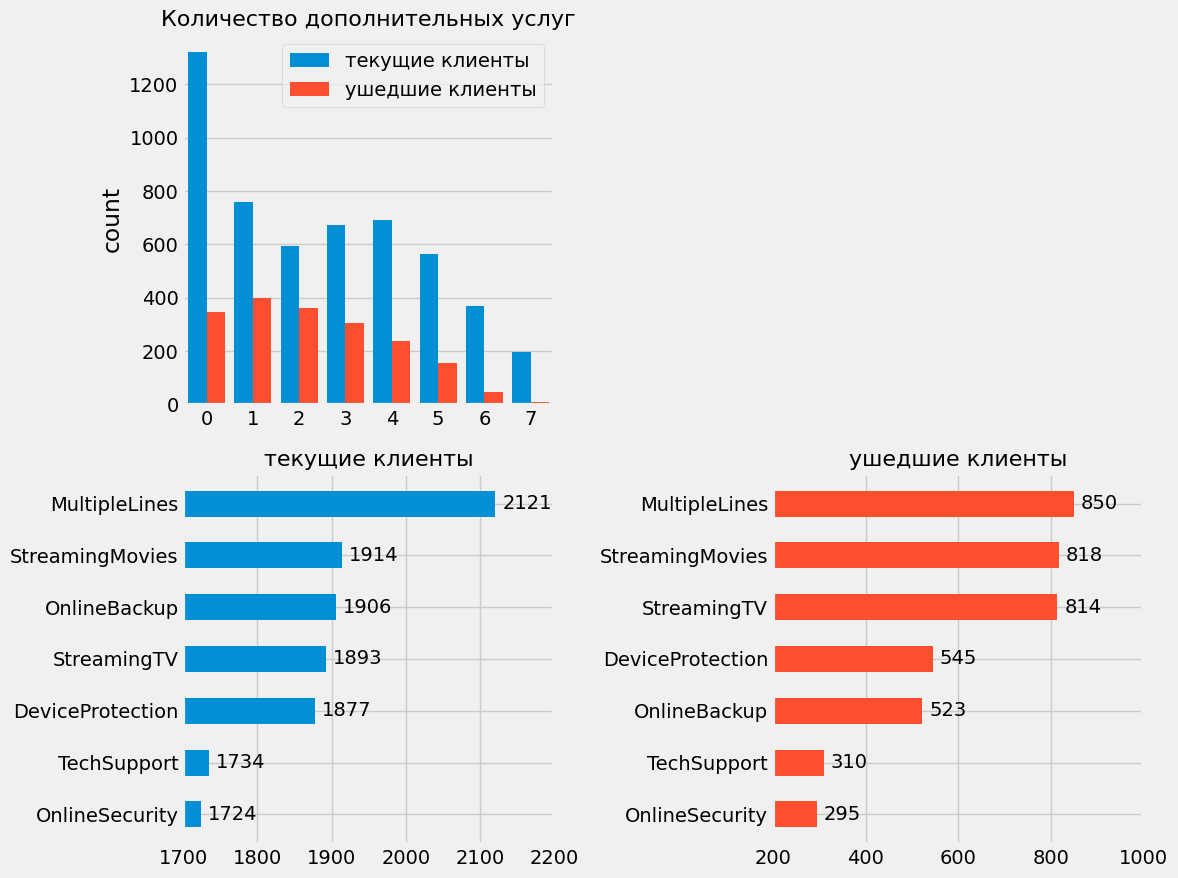

In [26]:
labels = ['текущие клиенты', 'ушедшие клиенты']

fig, ax = plt.subplots(nrows   = 2, 
                       ncols   = 2,
                       figsize = (12, 9))

ax = ax.flatten()

sns.countplot(data       = all_data, 
              x          = 'NumAddServices', 
              hue        = 'Churn', 
              saturation = 1, 
              ax         = ax[0])


ax[0].set(xlabel = None)
ax[0].legend(labels  = labels)
ax[0].set_title('Количество дополнительных услуг', fontsize = 16)

ax[1].set_axis_off()

for i, churn, label in zip([2,3], [False, True], labels):
    
    data = all_data[all_data.Churn == churn][additional_services].sum().sort_values()
    
    if i == 2:
        bars = ax[i].barh(y      = data.index,
                          width  = data.values,
                          height = 0.5)
    else: 
        bars = ax[i].barh(y    = data.index,
                          width  = data.values,
                          height = 0.5,
                          color  = '#fc4f30')
    
    ax[i].bar_label(bars, 
                    fmt     = '%.4g', 
                    padding = 5)
    
    ax[i].set_title(label, fontsize = 16)

ax[2].set_xlim(1700, 2200)
ax[3].set_xlim(200, 1000)

plt.tight_layout()
plt.show()

Среди ушедших клиентов больше всего пользующихся одной дополнительной услугой (среди текущих клиентов большинство не пользуется дополнительными услугами).

В обоих классах одинаковые Топ-5 используемых дополнительных услуг.

#### Услуги телефонии

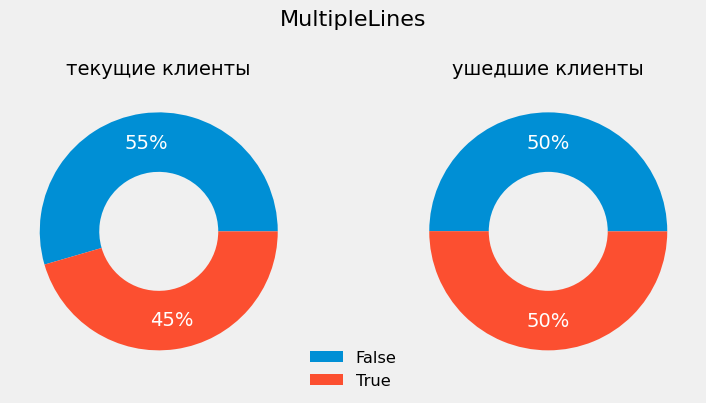

In [27]:
# применение функции plot_pie_feature
plot_pie_feature(all_data[all_data.Services != 'internet'], 'MultipleLines')

В обоих классах примерно у половины клиентов, пользующихся услугами телефонии, подключена дополнительная услуга `MultipleLines` (данный признак может быть малоинформативен).

#### Интернет-услуги

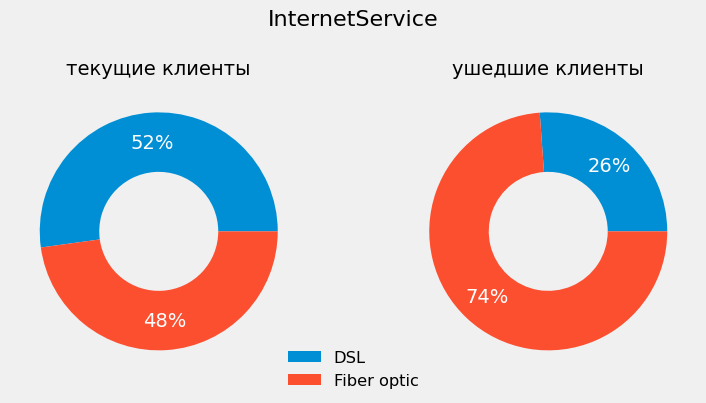

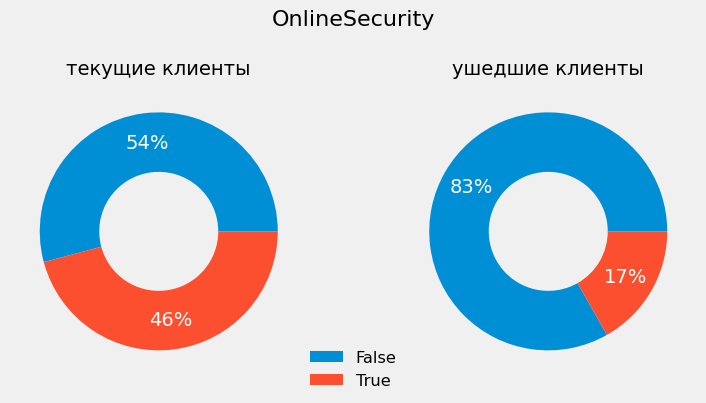

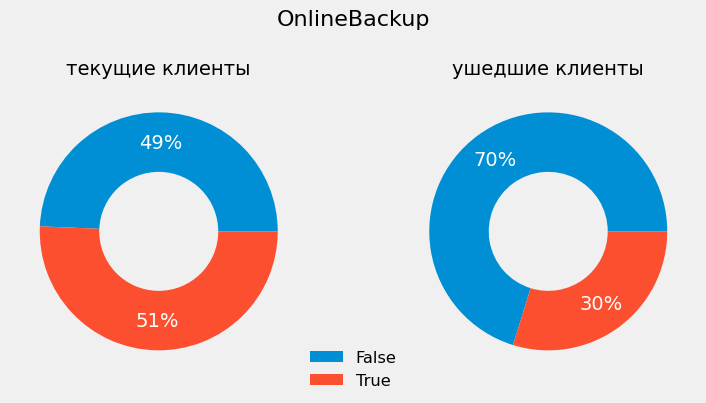

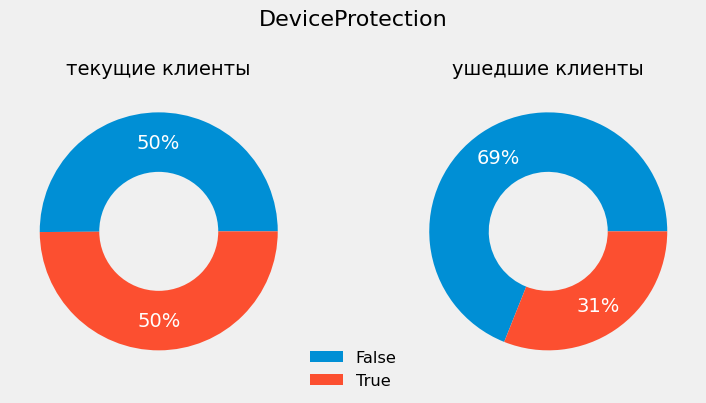

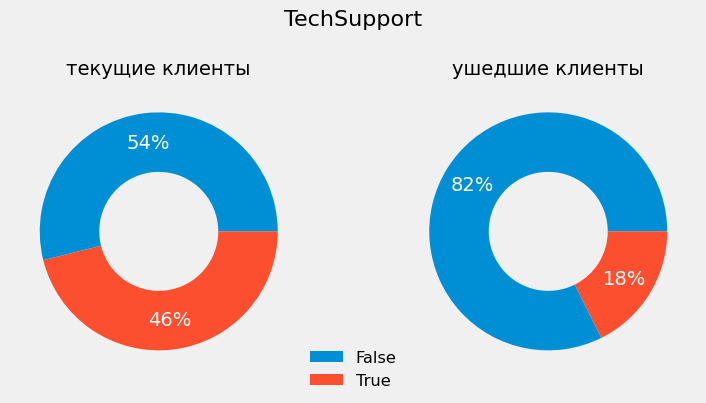

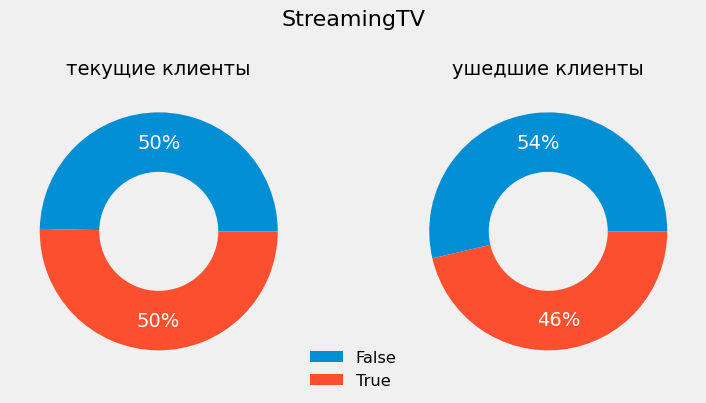

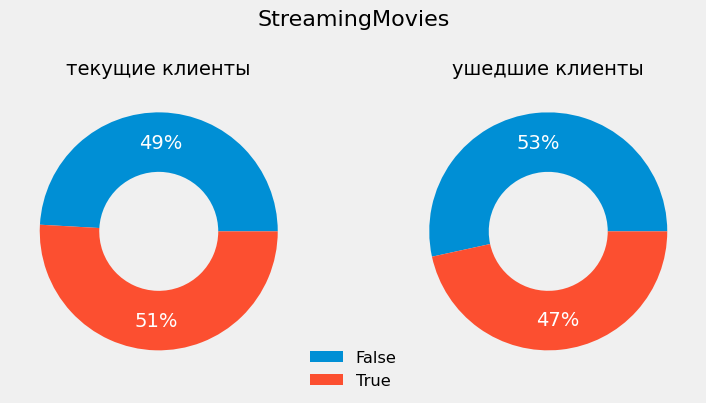

In [28]:
# создание списка с названиями категориальных признаков - интернет-услуг
cat_features_internet = ['InternetService', 'OnlineSecurity', 'OnlineBackup', 
                         'DeviceProtection', 'TechSupport', 'StreamingTV', 
                         'StreamingMovies']

# применение функции plot_pie_feature
for feature in cat_features_internet:
    plot_pie_feature(all_data[all_data.Services != 'phone'], feature)

Среди ушедших клиентов:
- вдове меньше использующих тип подключения `'DSL'` (26% против 52%);
- меньше доля пользующихся дополнительными услугами `OnlineSecurity`, `OnlineBackup`, `DeviceProtection` и `TechSupport`.

В обоих классах примерно половина клиентов пользуется дополнительными услугами `StreamingTV` и `StreamingMovies` (данные признаки могут быть малоинформативны).

#### Оплата услуг

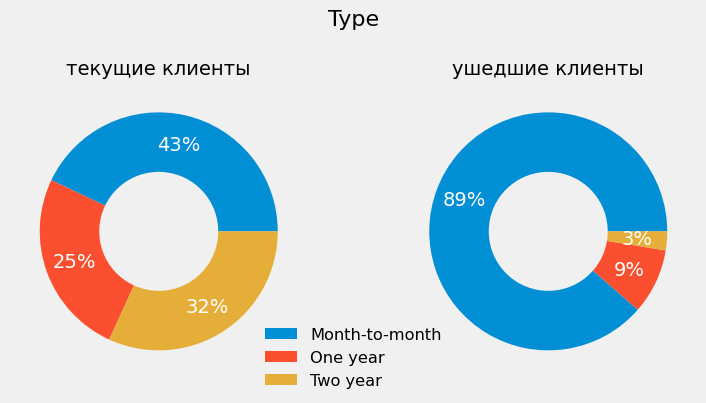

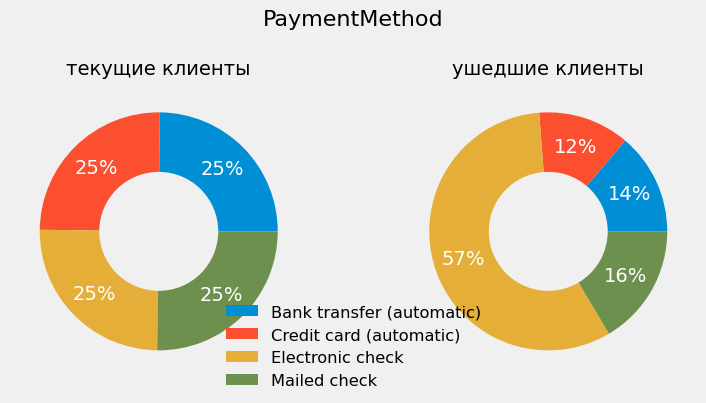

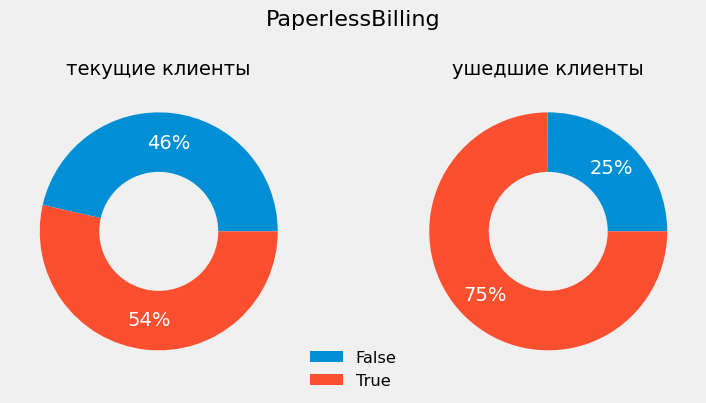

In [29]:
# создание списка с названиями категориальных признаков - оплаты услуг
cat_features_payment = ['Type', 'PaymentMethod', 'PaperlessBilling']

# применение функции plot_pie_feature
for feature in cat_features_payment:
    plot_pie_feature(all_data, feature)

Ушедшие клиенты:
- вдвое чаще предпочитают ежемесячную оплату услуг (89% против 43%) и получение счетов на оплату услуг по электронной почте (57% против 25%);
- чаще пользуются возможностью получения электронного чека (75% против 54%).

### Количественные признаки

In [30]:
# создание списка с названиямии количественных признаков
num_features = ['MonthlyCharges', 'TotalCharges', 'ContractDurationDays']

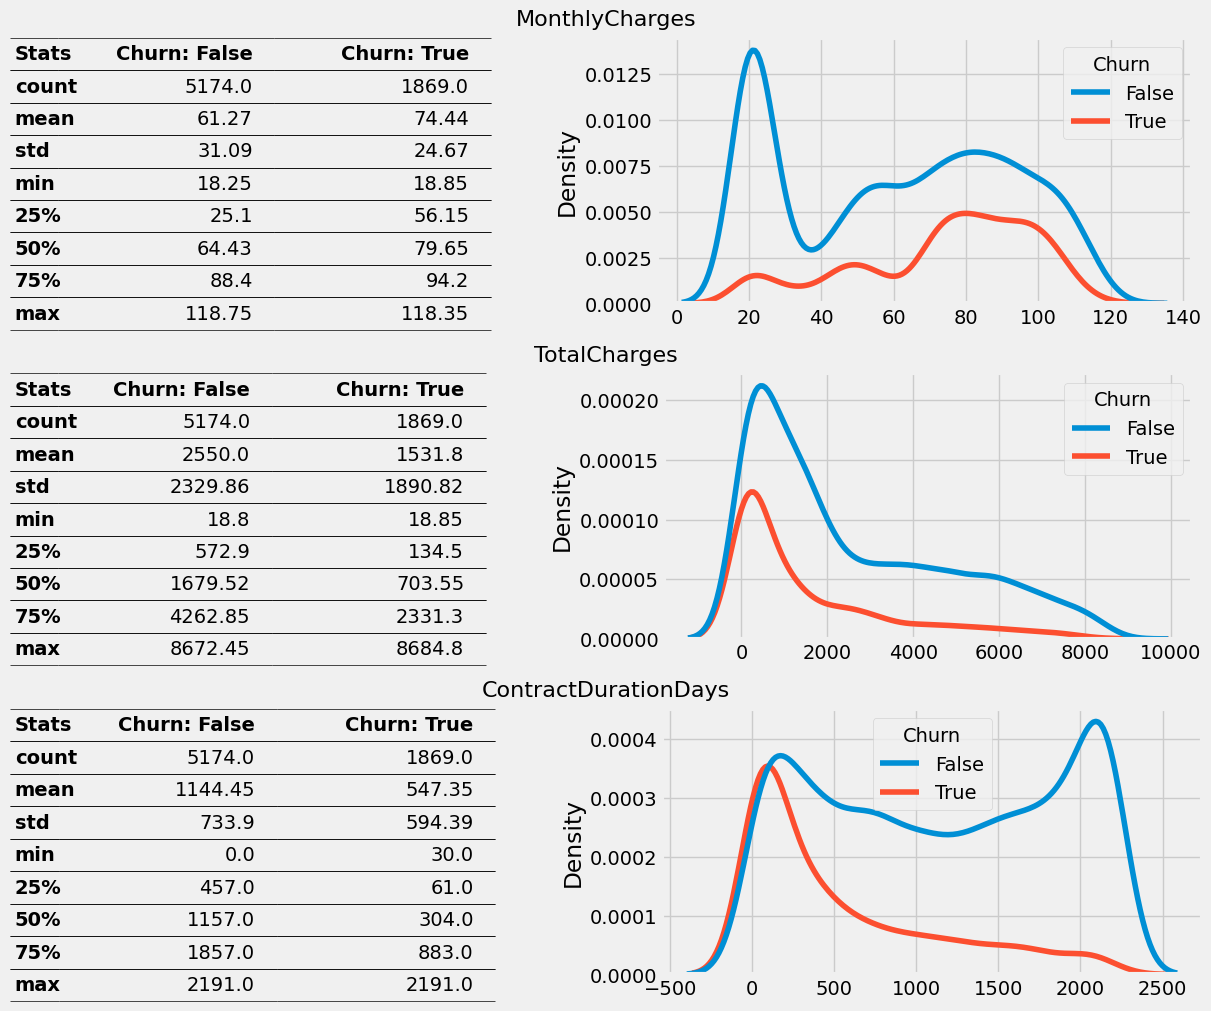

In [31]:
# по каждому количественному признаку вывод на экран описательной статистики и 
# графиков оценки распределения ядра по каждому классу
fig = plt.figure(constrained_layout = True, 
                 figsize            = (12, 10))

subfig = fig.subfigures(nrows = 3, 
                        ncols = 1)

for i, feature in enumerate(num_features):
    
    feature_stats = all_data.groupby('Churn')[feature].describe().T.round(2).reset_index()
    feature_stats.rename(columns = {'index' : 'Stats', 
                                    True    : 'Churn: True', 
                                    False   : 'Churn: False'}, 
                         inplace = True)
    

    subfig[i].suptitle(feature, fontsize = 16)

    ax = subfig[i].subplots(nrows = 1, 
                            ncols = 2)
    
    the_table = ax[0].table(cellText  = feature_stats.values, 
                            colLabels = feature_stats.columns, 
                            bbox      = (0, -0.1, 0.9, 1.1),
                            colWidths = [0.1, 0.45, 0.45],
                            edges     = 'horizontal')

    the_table.auto_set_font_size(False)
    the_table.set_fontsize(14)

    for k, cell in six.iteritems(the_table._cells):
        if k[1] == 0: cell.set_text_props(ha = 'left')
        else: cell.set_text_props(ha = 'right')
        if k[0] == 0 or k[1] == 0: cell.set_text_props(weight = 'bold')

    ax[0].axis('off')
    
    sns.kdeplot(data   = all_data, 
                x      = feature, 
                hue    = 'Churn',
                ax     = ax[1])
    
    ax[1].set(xlabel = None)

plt.show()

Среди ушедших клиентов:
- выше месячный средний чек (74 против 61) (что может объясняться более активным использованием дополнительных услуг) 
- в четыре раза меньше среднее количество дней пользования услугами (304 дня против 1157 дней).

### Корреляция

Для удобства анализа создадим функцию `plot_heatmap`:

In [32]:
# создание функции plot_heatmap
def plot_heatmap(data, title, figsize, zero_to_one = True):
    '''
    Функция выводит на экран график - тепловую карту.
    
    Параметры:
    - data — данные для построения графика;
    - title — название графика;
    - figsize — размер графика;
    - zero_to_one — находятся ли значения от 0 до 1.
    '''

    mask = np.zeros_like(data)
    mask[np.triu_indices_from(mask)] = True

    plt.figure(figsize = figsize)

    ax = sns.heatmap(data  = data,
                 cmap  = plt.colormaps['YlGn'].resampled(7),
                 annot = True,
                 fmt   = '.0f',
                 cbar  = False,
                 mask  = mask)
    
    if zero_to_one == True:
        for t in ax.texts: t.set_text("." + t.get_text())

    plt.grid(None)

    plt.xticks(rotation      = 45, 
            ha            = 'right', 
            rotation_mode = 'anchor')

    plt.suptitle(title, fontsize = 16)

    plt.tight_layout()
    plt.show()

#### Корреляция числовых признаков (корреляция Пирсона)

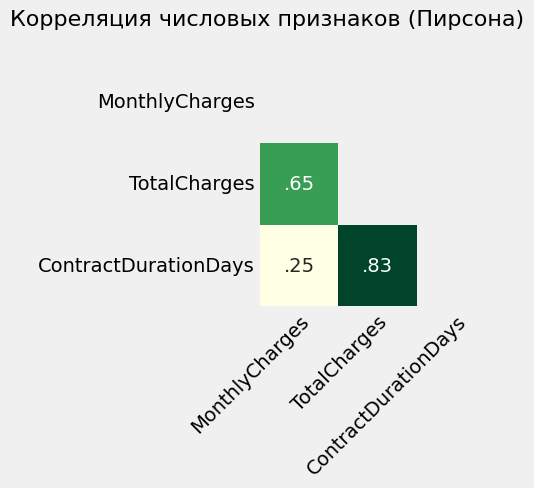

In [33]:
# построение матрицы корреляции Пирсона
pearson_corr = all_data[num_features].corr() * 100

# применение функции plot_heatmap
plot_heatmap(pearson_corr, 'Корреляция числовых признаков (Пирсона)', (5, 5))

Наблюдаются ожидаемые:

- заметная положительная корреляция между признаками `MonthlyCharges` и `TotalCharges`;
- высокая положительная корреляция между признаками `ContractDurationDays` и `TotalCharges`.

#### Корреляция всех признаков (корреляция Phik)

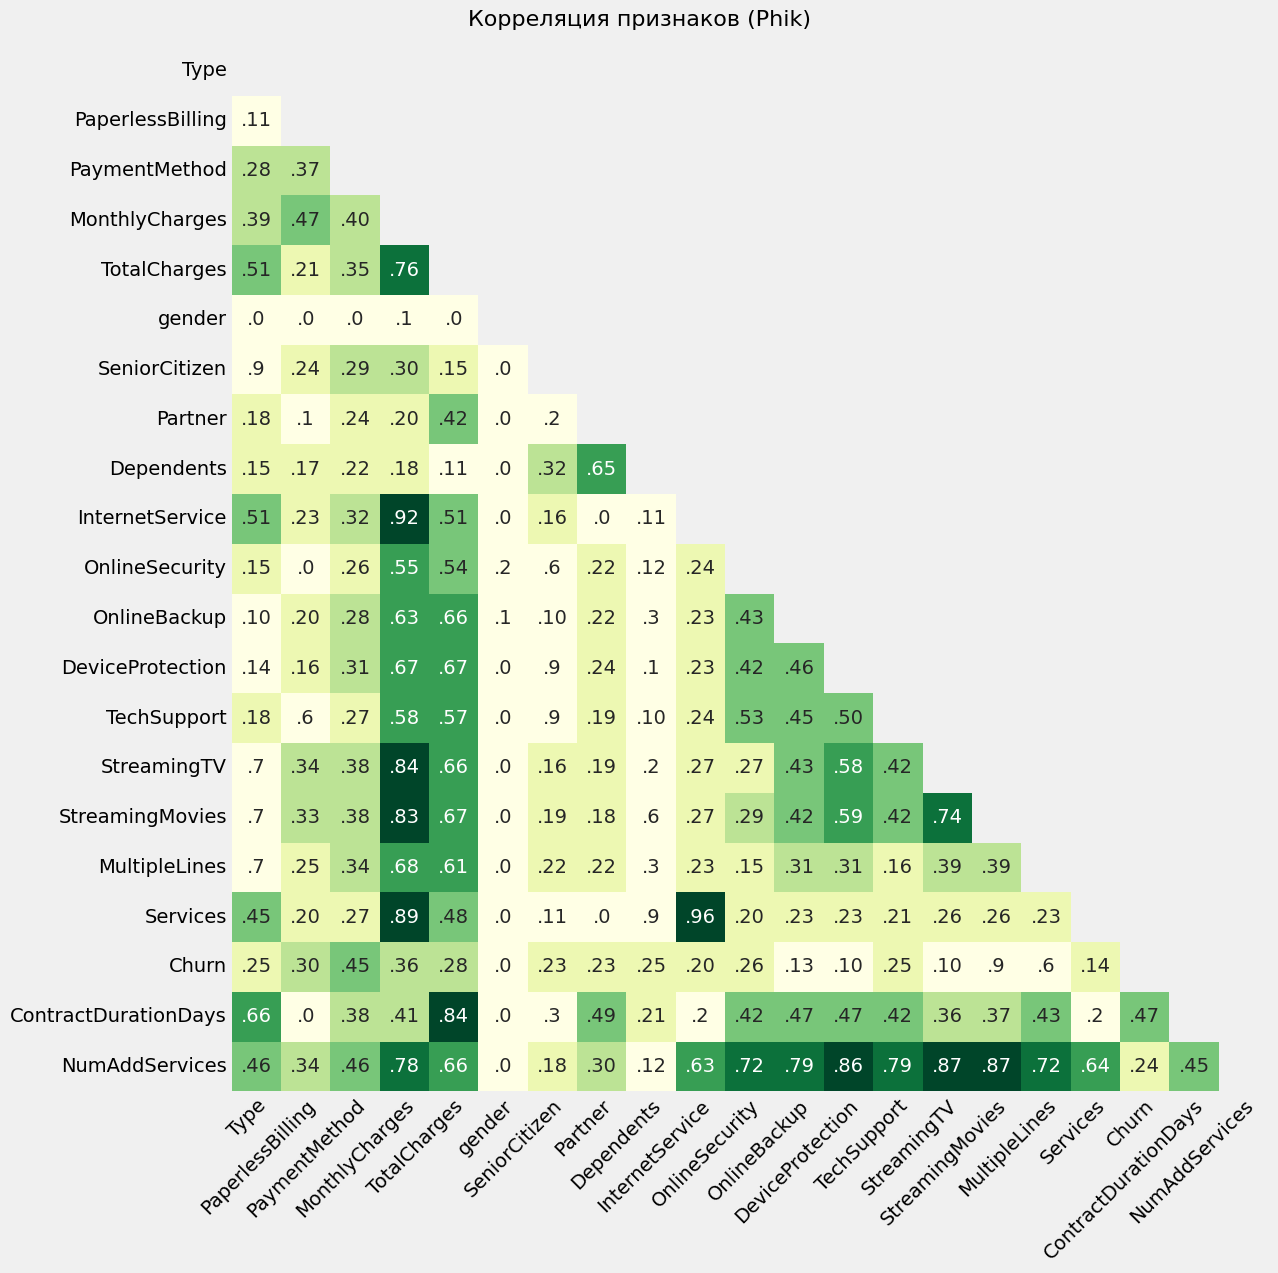

In [34]:
# построение матрицы корреляции Phik
phik_corr = all_data.drop(columns=['BeginDate', 'EndDate']).phik_matrix(interval_cols = num_features) * 100

# применение функции plot_heatmap
plot_heatmap(phik_corr, 'Корреляция признаков (Phik)', (13, 13))

- наибольшую корреляцию с целевым признаком `Churn` демонстрируют признаки: 
    - `ContractDurationDays` (0.47);
    - `PaymentMethod` (0.45);
    - `MonthlyCharges` (0.36); и
    - `PaperlessBilling` (0.30);
- наименьшую корреляцию с целевым признаком `Churn` демонстрируют признаки: 
    - `gender` (0);
    - `MultipleLines` (0.06);
    - `StreamingMovies` (0.09);
    - `StreamingTV` (0.10); и
    - `DeviceProtection` (0.10);
- признаки `Services` и `InternetService` и `Services` и `MonthlyCharges` демонстируют мультиколлинеарность;
- признак `gender` демонстрирует низкую корреляцию с другими признаками.

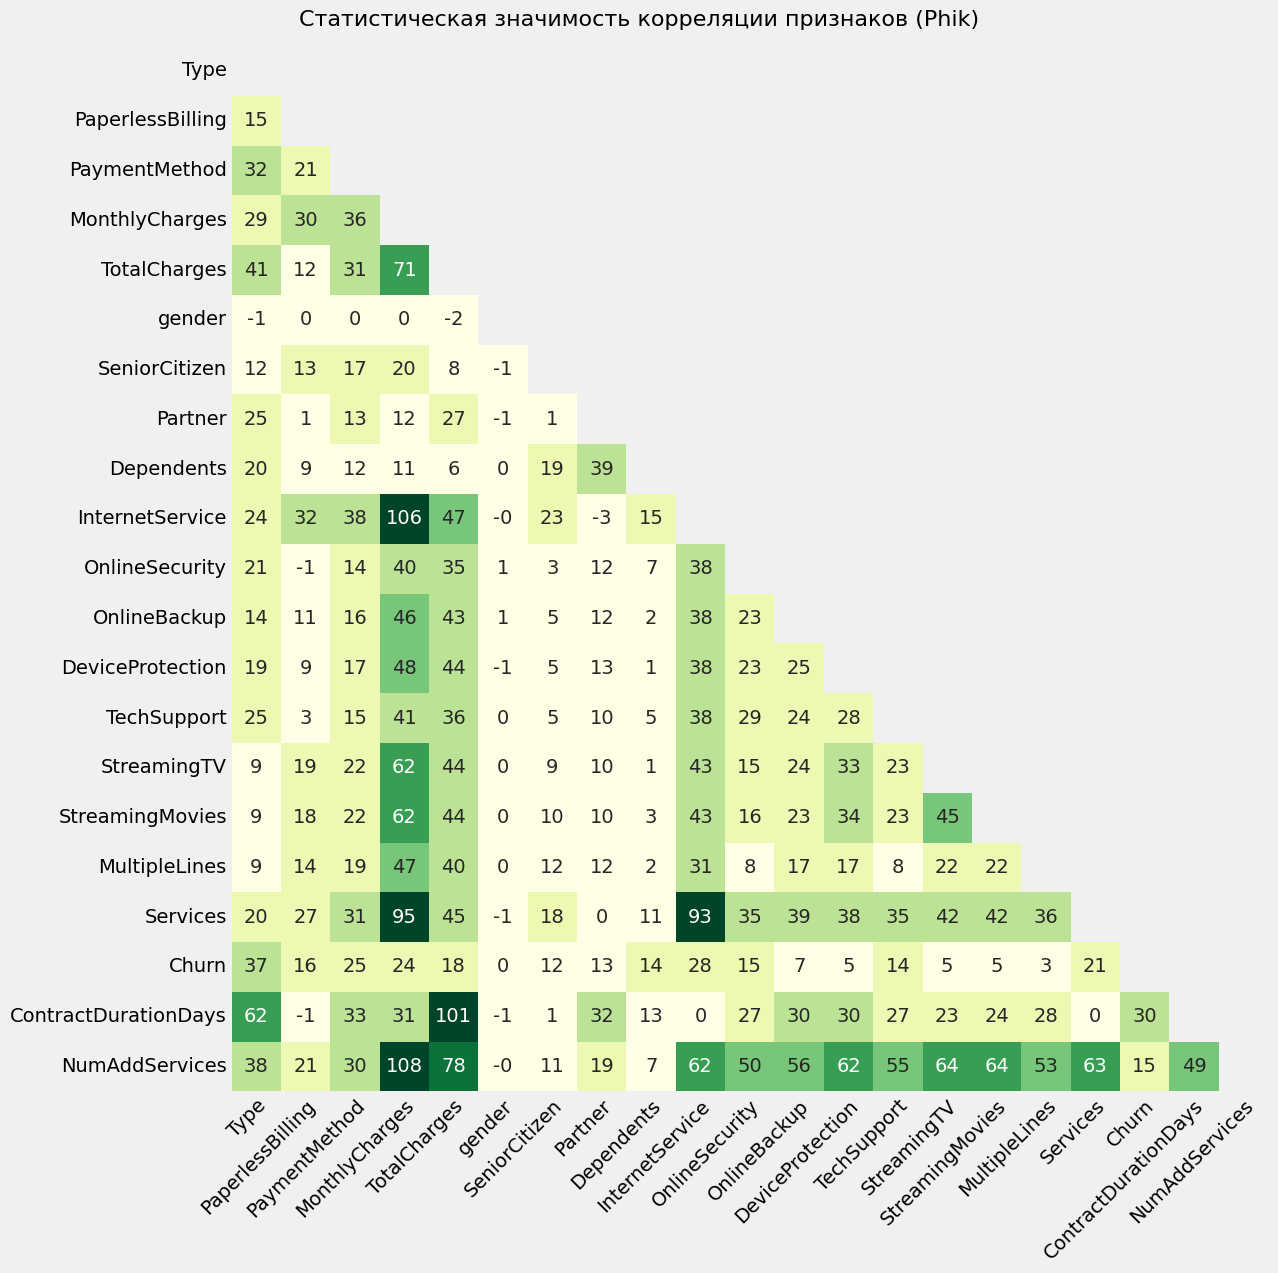

In [35]:
# построение матрицы статистической значимости корреляции Phik
phik_sign = all_data.drop(columns=['BeginDate', 'EndDate']).significance_matrix(interval_cols = num_features)

# применение функции plot_heatmap
plot_heatmap(phik_sign, 'Статистическая значимость корреляции признаков (Phik)', (13, 13), zero_to_one = False)

- признаки, демонстрирующие высокую корреляцию с целевым признаком, также демонстрирую высокую статистическую значимость; признаки, демонстрирующие низкую корреляцию с целевым признаком - низкую статистическую значимость.

### Выводы

В ходе исследовательского анализа мы:

- проанализировали соотношение классов;
- сравнили классы по различным признакам;
- изучили корреляцию признаков.

**Соотношение классов**

Классы несбалансированы — ушедшие пользователи составляют чуть больше четверти всей выборки.

Основаня целевая метрика — AUC-ROC — не чувствительна к дисбалансу классов, дополнительная — Accuracy — чувствительна, поэтому во время тестирования моделей стоит дополнительно изучить матрицы ошибок моделей.

**Сравнение классов по различным признакам**

*Персональные данные*

Среди ушедших клиентов:

- вдвое больше пенсионеров (25% против 13%); 
- на треть меньше имеющих партнеров (36% против 53%);
- вдвое меньше имеющих иждивенцев (17% против 34%).

В обоих классах примерно одинаковое разделение по полу (данный признак может быть малоинформативен).

*Используемые услуги*

Среди ушедших клиентов:

- на треть больше одновременно пользующихся услугами телефонии и интернет-услугами (85% против 63%); 
- значительно меньше пользующихся только услугами телефонии (6% против 27%).
- больше всего пользующихся одной дополнительной услугой (среди текущих клиентов большинство не пользуется дополнительными услугами).

В обоих классах одинаковые Топ-5 используемых дополнительных услуг.

*Услуги телефонии*

В обоих классах примерно у половины клиентов, пользующихся услугами телефонии, подключена дополнительная услуга `MultipleLines` (данный признак может быть малоинформативен).

*Интернет-услуги*

Среди ушедших клиентов:
- вдове меньше использующих тип подключения `'DSL'` (26% против 52%);
- меньше доля пользующихся дополнительными услугами `OnlineSecurity`, `OnlineBackup`, `DeviceProtection` и `TechSupport`.

В обоих классах примерно половина клиентов пользуется дополнительными услугами `StreamingTV` и `StreamingMovies` (данные признаки могут быть малоинформативны).

*Оплата услуг и период пользования услугами*

Ушедшие клиенты:

- вдвое чаще предпочитают ежемесячную оплату услуг (89% против 43%) и получение счетов на оплату услуг по электронной почте (57% против 25%);
- чаще пользуются возможностью получения электронного чека (75% против 54%).

Среди ушедших клиентов:

- выше месячный средний чек (74 против 61) (что может объясняться более активным использованием дополнительных услуг) 
- в четыре раза меньше среднее количество дней пользования услугами (304 дня против 1157 дней).

**Корреляция**

*Корреляция Пирсона*

Наблюдаются ожидаемые:

- заметная положительная корреляция между признаками `MonthlyCharges` и `TotalCharges`;
- высокая положительная корреляция между признаками `ContractDurationDays` и `TotalCharges`.

*Корреляция Phik*

- наибольшую корреляцию с целевым признаком `Churn` демонстрируют признаки: 
    - `ContractDurationDays` (0.47);
    - `PaymentMethod` (0.45);
    - `MonthlyCharges` (0.36); и
    - `PaperlessBilling` (0.30);
- наименьшую корреляцию с целевым признаком `Churn` демонстрируют признаки: 
    - `gender` (0);
    - `MultipleLines` (0.06);
    - `StreamingMovies` (0.09);
    - `StreamingTV` (0.10); и
    - `DeviceProtection` (0.10);
- признаки `Services` и `InternetService` и `Services` и `MonthlyCharges` демонстируют мультиколлинеарность;
- признак `gender` демонстрирует низкую корреляцию с другими признаками;
- признаки, демонстрирующие высокую корреляцию с целевым признаком, также демонстрирую высокую статистическую значимость; признаки, демонстрирующие низкую корреляцию с целевым признаком - низкую статистическую значимость.

## Подготовка к обучению моделей

На этапе подготовки к обучению моделей:

- отберем признаки для обучения;
- разделим данные на обучающую и тестовую выборки;
- создадим пайплайны для препроцессинга признаков.

### Отбор признаков для обучения

Исключим из обучения следующие признаки:

- `BeginDate`, `EndDate`  - данные признаки использовались только для создания новых признаков;
- `gender`, `DeviceProtection`, `StreamingTV`, `StreamingMovies`, `MultipleLines` - признаки демостритуют низкую корреляцию с целевым признаком и низкую статистическую значимость корреляции;

Сокращение количества признаков также повысит скорость обучения моделей.

Таким образом, для обучения будут использованы 15 признаков:

- `Type`;
- `PaperlessBilling`; 
- `PaymentMethod`;
- `MonthlyCharges`;
- `TotalCharges`;
- `SeniorCitizen`;
- `Partner`;
- `Dependents`;
- `InternetService`; 
- `OnlineSecurity`; 
- `OnlineBackup`;
- `TechSupport`;
- `Services`;
- `ContractDurationDays`;
- `NumAddServices`.

In [36]:
# создание переменных features и target с признаками и целевым признаком
features = all_data.drop(columns=['BeginDate', 'EndDate', 'gender', 'DeviceProtection', 'StreamingTV', 
                                  'StreamingMovies', 'MultipleLines', 'Churn'])
target = all_data['Churn'].astype('int8')

# проверка создания переменных
for subset_name, subset in zip(['features', 'target'], [features, target]):
    print(subset_name)
    print(subset.shape)
    print()

# создание списка с названиями категориальных признаков
cat_features = [feature for feature in features.columns if feature not in num_features]

print(f'categorical features:\n{cat_features}')

features
(7043, 15)

target
(7043,)

categorical features:
['Type', 'PaperlessBilling', 'PaymentMethod', 'SeniorCitizen', 'Partner', 'Dependents', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'TechSupport', 'Services', 'NumAddServices']


### Деление данных на обучающую и тестовую выборки

При делении используем пропорцию `3:1`. Поскольку классы несбалансированы, при разделении данных на выборки будем проводить стратификацию по целевому признаку:

In [37]:
# разделение данных на обучающую и тестовую выборки
features_train, features_test, target_train, target_test = train_test_split(features, 
                                                                            target, 
                                                                            test_size    = 0.25, 
                                                                            random_state = random_state,
                                                                            stratify     = target)

# создание словаря с признаками и целевым признаком по каждой выборке
subsets_dict = {'features_train' : features_train,
                'features_test'  : features_test,
                'target_train'   : target_train,
                'target_test'    : target_test}

# проверка разделения данных
for subset_name, subset in subsets_dict.items():
    print(subset_name)
    print(subset.shape)
    if 'target' in subset_name:
        display(subset.value_counts(normalize = True).to_frame())
    print()

features_train
(5282, 15)

features_test
(1761, 15)

target_train
(5282,)


,Churn
0,0.73457
1,0.26543



target_test
(1761,)


,Churn
0,0.73481
1,0.26519


### Cоздание пайплайнов для препроцессинга признаков

На следующем этапе мы планируем обучить шесть моделей:

- `LogisticRegression`;
- `SVC`;
- `RandomForestClassifier`;
- `KNeighborsClassifier`;
- `CatBoostClassifier`; и
- `XGBClassifier`,

среди которых:

- `LogisticRegression`, `SVC` и `KNeighborsClassifier` чувствительны в раличному масштабу количественных признаков;
- `LogisticRegression`, `SVC`, `RandomForestClassifier`, `KNeighborsClassifier` и `XGBClassifier` требуют кодирования категориальных признаков.

С учетом этого создадим пайпланы для препроцессинга признаков:

In [38]:
# создание объектов StandardScaler и OneHotEncoder
scaler = StandardScaler()
oth = OneHotEncoder(drop = 'first', sparse = False)

In [39]:
# создание пайплайнов для препроцессинга признаков
preprocessor_lr_svc_knn = ColumnTransformer(transformers = [('num',  scaler, num_features),
                                                            ('cat', oth, cat_features)
                                                           ]).set_output(transform = 'pandas')

preprocessor_rf_xgb = ColumnTransformer(transformers = [('cat', oth, cat_features)],
                                        remainder = 'passthrough').set_output(transform = 'pandas')

### Выводы

На этапе подготовки к обучению моделей мы:

- отобрали 15 признаков для обучения:
    - `Type`;
    - `PaperlessBilling`; 
    - `PaymentMethod`;
    - `MonthlyCharges`;
    - `TotalCharges`;
    - `SeniorCitizen`;
    - `Partner`;
    - `Dependents`;
    - `InternetService`; 
    - `OnlineSecurity`; 
    - `OnlineBackup`;
    - `TechSupport`;
    - `Services`;
    - `ContractDurationDays`;
    - `NumAddServices`;
- разделили данные на обучающую и тестовую выборки;
- создали пайплайны для препроцессинга признаков.

В состав признаков для обучения не вошли следующие признаки:

- `BeginDate`, `EndDate`  - данные признаки использовались только для создания новых признаков;
- `gender`, `DeviceProtection`, `StreamingTV`, `StreamingMovies`, `MultipleLines` - признаки демостритуют низкую корреляцию с целевым признаком и низкую статистическую значимость корреляции.

Сокращение количества признаков также повысит скорость обучения моделей.

Теперь мы можем перейти к обучению моделей.

## Обучение моделей

На данном этапе обучим шесть моделей:
- `LogisticRegression`;
- `SVC`;
- `RandomForestClassifier`;
- `KNeighborsClassifier`;
- `CatBoostClassifier`; и
- `XGBClassifier`,

а также константную модель `DummyClassifier`, предсказывающую самый популярный класс.

Для каждой из моделей (за исключением константной) оптимизируем гиперпараметры.

In [40]:
# создание моделей
dummy_model = DummyClassifier(strategy = 'most_frequent')

lr_model = Pipeline([
    ('preprocessor', preprocessor_lr_svc_knn),
    ('classifier', LogisticRegression(random_state = random_state))
])

svc_model = Pipeline([
    ('preprocessor', preprocessor_lr_svc_knn),
    ('classifier', SVC(probability  = True,
                       random_state = random_state))
])

rf_model = Pipeline([
    ('preprocessor', preprocessor_rf_xgb),
    ('classifier', RandomForestClassifier(random_state = random_state))
])

knn_model = Pipeline([
    ('preprocessor', preprocessor_lr_svc_knn),
    ('classifier', KNeighborsClassifier())
])

cb_model = CatBoostClassifier(cat_features = cat_features,
                              random_state = random_state, 
                              verbose      = False)

xgb_model = Pipeline([
    ('preprocessor', preprocessor_rf_xgb),
    ('classifier', XGBClassifier(random_state = random_state))
])

In [41]:
# создание списков models и models_names с моделями и их названиями
models = [dummy_model, lr_model, svc_model, rf_model, knn_model, cb_model, xgb_model]

models_names = ['DummyClassifier', 'LogisticRegression', 'SVC', 'RandomForestClassifier', 'KNeighborsClassifier', 
                'CatBoostClassifier', 'XGBClassifier']

# создание таблицы models_data для хранения параметров и результатов обучениея моделей
models_data = pd.DataFrame({'model_name' : models_names})

models_data.set_index('model_name', inplace = True)

Для удобства обучения создадим функции:
- `plot_scores` (для визуализации метрик);
- `plot_param_perm_importances` (для визуализации важности гиперпараметров и признаков)

In [42]:
# создание функции plot_scores
def plot_scores(stage, title):
    '''
    Функция строит графики значений AUC-ROC и Accuracy по каждой модели.
    
    Параметры:
    - stage — этап, по которому необходимо построить графики;
    - title — название графиков.
    '''

    fig, ax = plt.subplots(nrows   = 1, 
                        ncols      = 2,
                        figsize    = (13, 4))

    for i, metric in enumerate(scoring):
        
        data = models_data[stage + '_' + metric].sort_values(ascending = True)
        
        if i == 0:
            bars = ax[i].barh(y      = data.index,
                              width  = data.values,
                              height = 0.5)
        else: 
            bars = ax[i].barh(y      = data.index,
                              width  = data.values,
                              height = 0.5,
                              color  = '#fc4f30')
        
        ax[i].bar_label(bars, 
                        fmt     = '%.4g', 
                        padding = 5)
        
        ax[i].set(ylabel = None)
        ax[i].set_title(metric, fontsize = 16)

    ax[0].set_xlim(0.45, 1)
    ax[1].set_xlim(0.7, 0.9)

    fig.suptitle(title, fontsize = 16)

    plt.tight_layout()
    plt.show()

In [43]:
def plot_param_perm_importances(study, model):
    '''
    Функция строит графики важности гиперпараметров и признаков.
    
    Параметры:
    - study — результаты оптимизации гиперпараметров;
    - model — модель, для которой нужно построить графики.
    '''

    hpi = optuna.importance.get_param_importances(study)
    
    model.fit(features_train, target_train)
    
    fi = permutation_importance(model, 
                                features_train, 
                                target_train,
                                scoring = 'roc_auc', 
                                n_repeats = 10, 
                                random_state = random_state)

    inds = fi.importances_mean.argsort()

    fig, ax = plt.subplots(nrows   = 1,
                           ncols   = 2,
                           figsize = (13, 6))

    hpi_bars = ax[0].barh(y      = list(hpi.keys())[::-1],
                          width  = list(hpi.values())[::-1],
                          height = 0.5,
                          color  = '#e5ae38')

    ax[0].bar_label(hpi_bars, 
                    fmt     = '%.2g', 
                    padding = 5)
    
    fi_bars = ax[1].barh(y     = features.columns[inds],
                         width = fi.importances_mean[inds],
                         height = 0.5,
                         color = '#6d904f')

    ax[1].bar_label(fi_bars, 
                    fmt     = '%.2g', 
                    padding = 5)

    ax[0].set_title('Hyperparameter Importance', fontsize = 16)
    ax[1].set_title('Permutation Importance', fontsize = 16)

    plt.tight_layout()
    plt.show()

In [44]:
# фиксирование количества сплитов для StratifiedKFold
splits = 10

# создание объекта StratifiedKFold
skf = StratifiedKFold(n_splits = splits, 
                      shuffle = True, 
                      random_state = random_state)

# создание списка с метриками
scoring = ['roc_auc', 'accuracy']

# создание объекта TPESampler для воспроизводимости результатов оптимизации гиперпараметров
sampler = TPESampler(seed = random_state)

### Baseline

Посчитаем метрики для моделей на дефолтных параметрах:

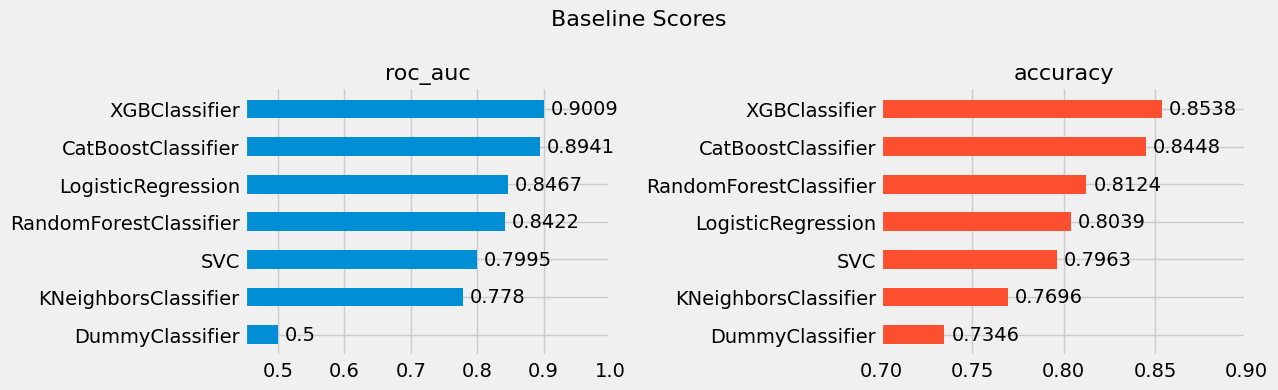

In [45]:
# для каждой модели
for model_name, model in zip(models_names, models):
    
    # расчет средних значений auc-roc и accuracy на обучающей выборке (с кросс-валидацией)
    cv_results = cross_validate(model, 
                                features_train, 
                                target_train, 
                                scoring = scoring, 
                                cv      = skf)
    
    # сохранение результатов
    models_data.loc[model_name, 'baseline_roc_auc'] = np.mean(cv_results['test_roc_auc'])
    models_data.loc[model_name, 'baseline_accuracy'] = np.mean(cv_results['test_accuracy'])

# применение функции plot_scores
plot_scores('baseline', 'Baseline Scores')

- лучшие значения метрик `AUC-ROC` (`0.9009`) и `Accuracy` показала модель `XGBClassifier` (`0.8538`);
- только 2 модели (`XGBClassifier` и `CatBoostClassifier`) показали значения метрики `AUC-ROC` выше целевого целевого значения `0.85`;
- худший результат показала константная модель.

### LogisticRegression

In [46]:
# создание функции objective для оптимизации гиперпараметров
def objective(trial, scoring):
    
    # определение пространства поиска значений гиперпараметров
    params = {'classifier__C'            : trial.suggest_float('C', 1e-3, 1e3, log = True), 
              'classifier__penalty'      : trial.suggest_categorical('penalty', [None, 'l1', 'l2']),
              'classifier__class_weight' : trial.suggest_categorical('class_weight', [None, 'balanced']),
              'classifier__solver'       : 'saga'}
    
    # обновление гиперпараметров модели
    lr_model.set_params(**params)
    
    # расчет среднего значения auc-roc на обучающей выборке (с кросс-валидацией)   
    scores = cross_val_score(lr_model, 
                             features_train, 
                             target_train, 
                             scoring = scoring, 
                             cv      = skf)

    return scores.mean()

In [47]:
model_name = 'LogisticRegression'

# оптимизация гиперпараметров
func = lambda trial: objective(trial, scoring = 'roc_auc')
lr_study = optuna.create_study(direction = 'maximize', sampler = sampler)
lr_study.optimize(func, n_trials = 100, show_progress_bar = True)

# расчет среднего значения accuracy на обучающей выборке (с кросс-валидацией) 
# для модели с оптимизированными гиперпараметрами
opt_hparams_accuracy = objective(lr_study.best_trial, scoring = 'accuracy')

# сохранение результатов оптимизации гиперпараметров
joblib.dump(lr_study, os.path.join(path, 'lr_optuna_study.pkl'))
models_data.loc[model_name, 'opt_hparams_roc_auc'] = lr_study.best_value
models_data.loc[model_name, 'opt_hparams_accuracy'] = opt_hparams_accuracy
models_data.loc[model_name, 'best_params'] = [lr_study.best_params]

# вывод на экран лучших значений гиперпараметров
print(f'Best params:\n')
for parameter, value in lr_study.best_params.items():
    print(f'{parameter}: {value}')
print()

# вывод на экран значений auc-roc и accuracy до и после оптимизации гиперпараметров
metrics_to_display = ['baseline_roc_auc', 'opt_hparams_roc_auc', 'baseline_accuracy', 'opt_hparams_accuracy']
models_data.loc[model_name, metrics_to_display].to_frame()

Best params:

C: 1.0673218550157233
penalty: l1
class_weight: None



,LogisticRegression
baseline_roc_auc,0.846677
opt_hparams_roc_auc,0.847021
baseline_accuracy,0.803864
opt_hparams_accuracy,0.803675


- оптимизация гиперпараметров незначительно улучшила значение метрики `AUC-ROC` (но при этом она все еще ниже целевого значения `0.85`) и ухудшила значение метрики `Accuracy` 

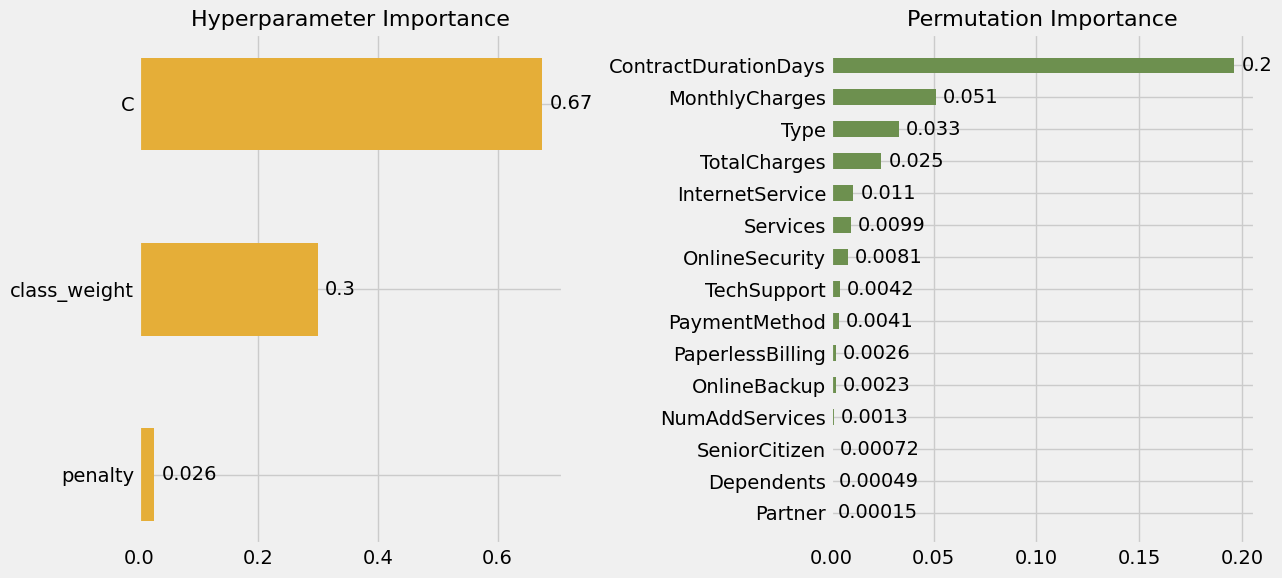

In [48]:
# применение функции plot_param_perm_importances
plot_param_perm_importances(lr_study, lr_model)

- наиболее важный гиперпараметр (с большим отрывом) — `class_weight`;
- наиболее важный признак (с большим отрывом) — `ContractDurationDays`;
- все признаки демонстируют положительные значения, поэтому сохраним все признаки

### SVC

In [49]:
# создание функции objective для оптимизации гиперпараметров
def objective(trial, scoring):
    
    # определение пространства поиска значений гиперпараметров
    params = {'classifier__C'            : trial.suggest_float('C', 1e-3, 1e3, log = True), 
              'classifier__kernel'       : trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid']),
              'classifier__class_weight' : trial.suggest_categorical('class_weight', [None, 'balanced']),
              'classifier__gamma'        : trial.suggest_float('gamma', 1e-3, 1, log = True)}

    # обновление гиперпараметров модели
    svc_model.set_params(**params)

    # расчет среднего значения auc-roc на обучающей выборке (с кросс-валидацией)                      
    scores = cross_val_score(svc_model, 
                             features_train, 
                             target_train, 
                             scoring = scoring, 
                             cv      = skf)

    return scores.mean()

In [50]:
model_name = 'SVC'

# оптимизация гиперпараметров
func = lambda trial: objective(trial, scoring = 'roc_auc')
svc_study = optuna.create_study(direction = 'maximize', sampler = sampler)
svc_study.optimize(func, n_trials = 100, show_progress_bar = True)

# расчет среднего значения accuracy на обучающей выборке (с кросс-валидацией) 
# для модели с оптимизированными гиперпараметрами
opt_hparams_accuracy = objective(svc_study.best_trial, scoring = 'accuracy')

# сохранение результатов оптимизации гиперпараметров
joblib.dump(svc_study, os.path.join(path, 'svc_optuna_study.pkl'))
models_data.loc[model_name, 'opt_hparams_roc_auc'] = svc_study.best_value
models_data.loc[model_name, 'opt_hparams_accuracy'] = opt_hparams_accuracy
models_data.loc[model_name, 'best_params'] = [svc_study.best_params]

# вывод на экран лучших значений гиперпараметров
print(f'Best params:\n')
for parameter, value in svc_study.best_params.items():
    print(f'{parameter}: {value}')
print()

# вывод на экран значений auc-roc и accuracy до и после оптимизации гиперпараметров
metrics_to_display = ['baseline_roc_auc', 'opt_hparams_roc_auc', 'baseline_accuracy', 'opt_hparams_accuracy']
models_data.loc[model_name, metrics_to_display].to_frame()

Best params:

C: 0.04932603195142028
kernel: linear
class_weight: balanced
gamma: 0.1645367258502422



,SVC
baseline_roc_auc,0.799515
opt_hparams_roc_auc,0.843696
baseline_accuracy,0.796291
opt_hparams_accuracy,0.738551


- оптимизация гиперпараметров существенно улучшила значение метрики `AUC-ROC` (но при этом она все еще ниже целевого значения `0.85`), но также ухудшила значение метрики `Accuracy` 

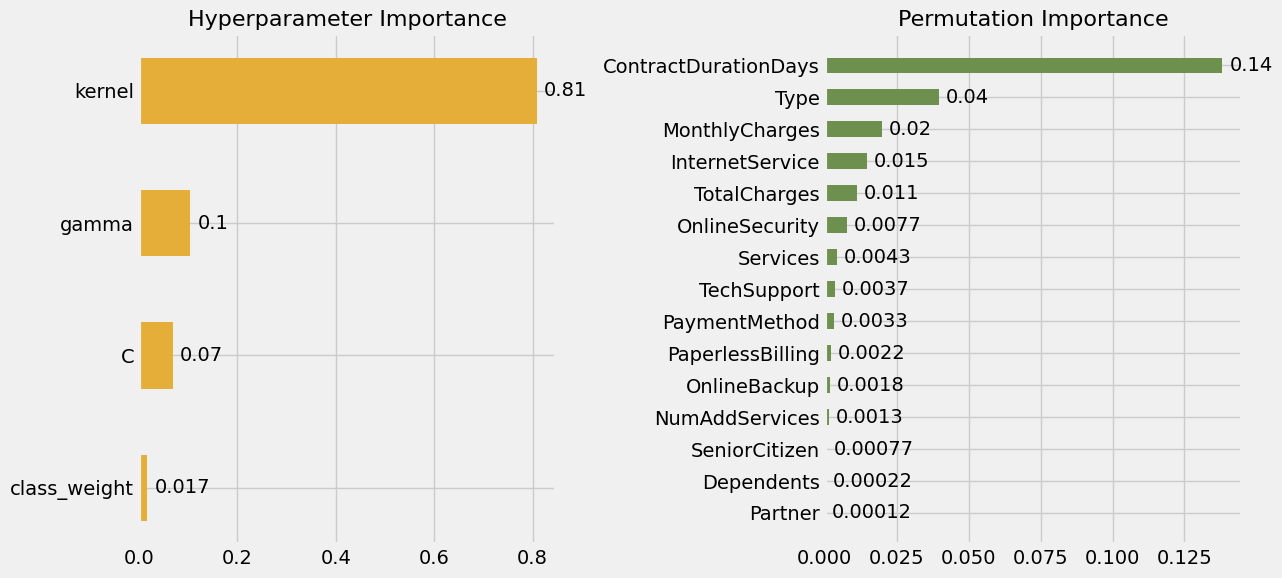

In [51]:
# применение функции plot_param_perm_importances
plot_param_perm_importances(svc_study, svc_model)

- наиболее важный гиперпараметр (с большим отрывом) — `kernel`;
- наиболее важный признак (с большим отрывом) — `ContractDurationDays`;
- все признаки демонстируют положительные значения, поэтому сохраним все признаки

### RandomForestClassifier

In [52]:
# создание функции objective для оптимизации гиперпараметров
def objective(trial, scoring):

    # определение пространства поиска значений гиперпараметров    
    params = {'classifier__n_estimators'      : trial.suggest_int('n_estimators', 50, 1000, step = 50), 
              'classifier__max_depth'         : trial.suggest_int('max_depth', 2, 50),
              'classifier__min_samples_split' : trial.suggest_int('min_samples_split', 2, 20),
              'classifier__min_samples_leaf'  : trial.suggest_int('min_samples_leaf', 1, 20),
              'classifier__max_features'      : trial.suggest_categorical('max_features', ['sqrt', 'log2']),
              'classifier__class_weight'      : trial.suggest_categorical('class_weight', [None, 'balanced'])}
    
    # обновление гиперпараметров модели    
    rf_model.set_params(**params)

    # расчет среднего значения auc-roc на обучающей выборке (с кросс-валидацией)                          
    scores = cross_val_score(rf_model, 
                             features_train, 
                             target_train, 
                             scoring = scoring, 
                             cv      = skf)

    return scores.mean()

In [53]:
model_name = 'RandomForestClassifier'

# оптимизация гиперпараметров
func = lambda trial: objective(trial, scoring = 'roc_auc')
rf_study = optuna.create_study(direction = 'maximize', sampler = sampler)
rf_study.optimize(func, n_trials = 100, show_progress_bar = True)

# расчет среднего значения accuracy на обучающей выборке (с кросс-валидацией) 
# для модели с оптимизированными гиперпараметрами
opt_hparams_accuracy = objective(rf_study.best_trial, scoring = 'accuracy')

# сохранение результатов оптимизации гиперпараметров
joblib.dump(rf_study, os.path.join(path, 'rf_optuna_study.pkl'))
models_data.loc[model_name, 'opt_hparams_roc_auc'] = rf_study.best_value
models_data.loc[model_name, 'opt_hparams_accuracy'] = opt_hparams_accuracy
models_data.loc[model_name, 'best_params'] = [rf_study.best_params]

# вывод на экран лучших значений гиперпараметров
print(f'Best params:\n')
for parameter, value in rf_study.best_params.items():
    print(f'{parameter}: {value}')
print()

# вывод на экран значений auc-roc и accuracy до и после оптимизации гиперпараметров
metrics_to_display = ['baseline_roc_auc', 'opt_hparams_roc_auc', 'baseline_accuracy', 'opt_hparams_accuracy']
models_data.loc[model_name, metrics_to_display].to_frame()

Best params:

n_estimators: 800
max_depth: 9
min_samples_split: 17
min_samples_leaf: 1
max_features: sqrt
class_weight: None



,RandomForestClassifier
baseline_roc_auc,0.842219
opt_hparams_roc_auc,0.861204
baseline_accuracy,0.812387
opt_hparams_accuracy,0.819959


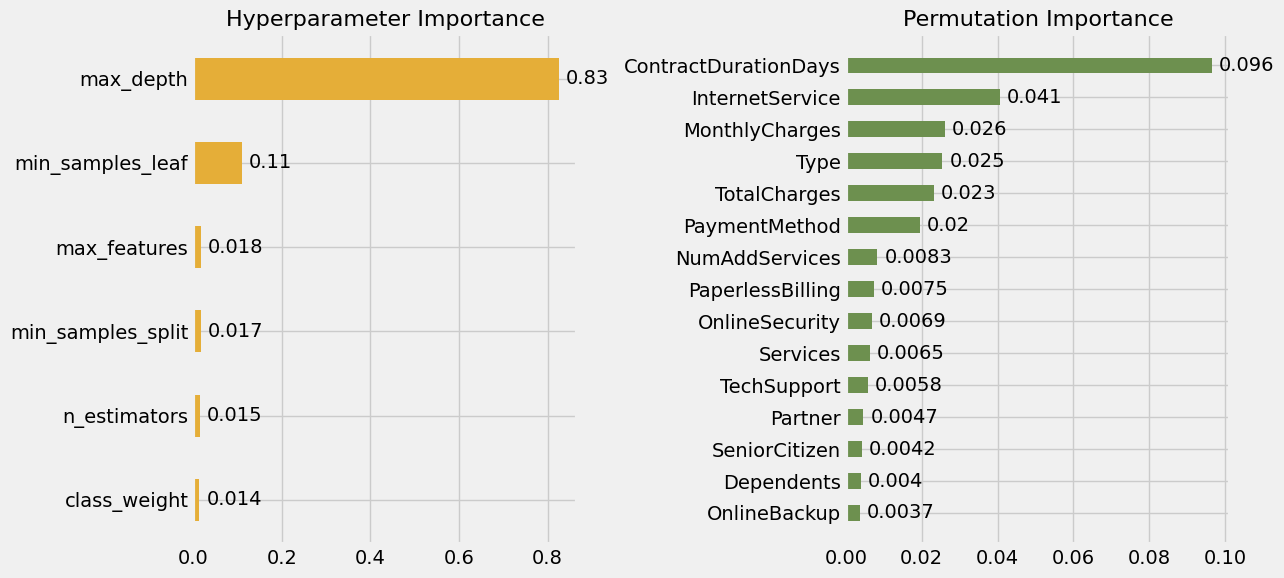

In [54]:
# применение функции plot_param_perm_importances
plot_param_perm_importances(rf_study, rf_model)

- наиболее важный гиперпараметр (с большим отрывом) — `max_depth`;
- наиболее важный признак (с большим отрывом) — `ContractDurationDays`;
- все признаки демонстируют положительные значения, поэтому сохраним все признаки

### KNeighborsClassifier

In [55]:
# создание функции objective для оптимизации гиперпараметров
def objective(trial, scoring):

    # определение пространства поиска значений гиперпараметров    
    params = {'classifier__n_neighbors' : trial.suggest_int('n_neighbors', 3, 100), 
              'classifier__weights'     : trial.suggest_categorical('weights', ['uniform', 'distance']),
              'classifier__metric'      : trial.suggest_categorical('metric', ['euclidean', 'manhattan', 'minkowski'])}

    # обновление гиперпараметров модели
    knn_model.set_params(**params)

    # расчет среднего значения auc-roc на обучающей выборке (с кросс-валидацией)                           
    scores = cross_val_score(knn_model, 
                             features_train, 
                             target_train, 
                             scoring = scoring, 
                             cv      = skf)

    return scores.mean()

In [56]:
model_name = 'KNeighborsClassifier'

# оптимизация гиперпараметров
func = lambda trial: objective(trial, scoring = 'roc_auc')
knn_study = optuna.create_study(direction = 'maximize', sampler = sampler)
knn_study.optimize(func, n_trials = 100, show_progress_bar = True)

# расчет среднего значения accuracy на обучающей выборке (с кросс-валидацией) 
# для модели с оптимизированными гиперпараметрами
opt_hparams_accuracy = objective(knn_study.best_trial, scoring = 'accuracy')

# сохранение результатов оптимизации гиперпараметров
joblib.dump(knn_study, os.path.join(path, 'knn_optuna_study.pkl'))
models_data.loc[model_name, 'opt_hparams_roc_auc'] = knn_study.best_value
models_data.loc[model_name, 'opt_hparams_accuracy'] = opt_hparams_accuracy
models_data.loc[model_name, 'best_params'] = [knn_study.best_params]

# вывод на экран лучших значений гиперпараметров
print(f'Best params:\n')
for parameter, value in knn_study.best_params.items():
    print(f'{parameter}: {value}')
print()

# вывод на экран значений auc-roc и accuracy до и после оптимизации гиперпараметров
metrics_to_display = ['baseline_roc_auc', 'opt_hparams_roc_auc', 'baseline_accuracy', 'opt_hparams_accuracy']
models_data.loc[model_name, metrics_to_display].to_frame()

Best params:

n_neighbors: 74
weights: uniform
metric: manhattan



,KNeighborsClassifier
baseline_roc_auc,0.777962
opt_hparams_roc_auc,0.837678
baseline_accuracy,0.769596
opt_hparams_accuracy,0.796668


- оптимизация гиперпараметров существенно улучшила значения метрики `AUC-ROC` (но при этом она все еще ниже целевого значения `0.85`) и метрики `Accuracy` 

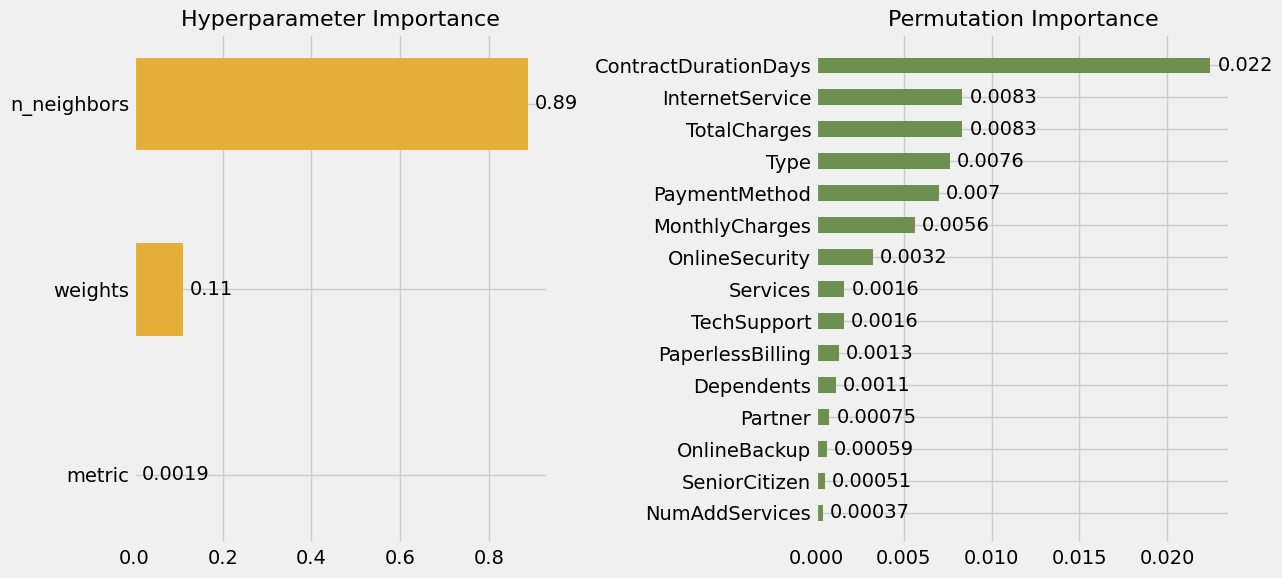

In [57]:
# применение функции plot_param_perm_importances
plot_param_perm_importances(knn_study, knn_model)

- наиболее важный гиперпараметр (с большим отрывом) — `n_neighbors`;
- наиболее важный признак (с большим отрывом) — `ContractDurationDays`;
- все признаки демонстируют положительные значения, поэтому сохраним все признаки

### CatBoostClassifier

In [58]:
# создание функции objective для оптимизации гиперпараметров
def objective(trial, scoring):

    # определение пространства поиска значений гиперпараметров    
    params = {'iterations'      : trial.suggest_int('iterations', 50, 1000, step = 50), 
              'learning_rate'   : trial.suggest_float('learning_rate', 1e-4, 3e-1, log = True),
              'depth'           : trial.suggest_int('depth', 2, 10),
              'l2_leaf_reg'     : trial.suggest_float('l2_leaf_reg', 1e-3, 1e3, log = True),
              'random_strength' : trial.suggest_float('random_strength', 1e-3, 1e3, log = True),
              'class_weights'   : trial.suggest_categorical('class_weights', [[1, 1], [73, 27]])}

    # обновление гиперпараметров модели    
    cb_model.set_params(**params)

    # расчет среднего значения auc-roc на обучающей выборке (с кросс-валидацией)                          
    scores = cross_val_score(cb_model, 
                             features_train, 
                             target_train, 
                             scoring = scoring, 
                             cv      = skf)

    return scores.mean()

In [59]:
model_name = 'CatBoostClassifier'

# оптимизация гиперпараметров
func = lambda trial: objective(trial, scoring = 'roc_auc')
cb_study = optuna.create_study(direction = 'maximize', sampler = sampler)
cb_study.optimize(func, n_trials = 100, show_progress_bar = True)

# расчет среднего значения accuracy на обучающей выборке (с кросс-валидацией) 
# для модели с оптимизированными гиперпараметрами
opt_hparams_accuracy = objective(cb_study.best_trial, scoring = 'accuracy')

# сохранение результатов оптимизации гиперпараметров
joblib.dump(cb_study, os.path.join(path, 'cb_optuna_study.pkl'))
models_data.loc[model_name, 'opt_hparams_roc_auc'] = cb_study.best_value
models_data.loc[model_name, 'opt_hparams_accuracy'] = opt_hparams_accuracy
models_data.loc[model_name, 'best_params'] = [cb_study.best_params]

# вывод на экран лучших значений гиперпараметров
print(f'Best params:\n')
for parameter, value in cb_study.best_params.items():
    print(f'{parameter}: {value}')
print()

# вывод на экран значений auc-roc и accuracy до и после оптимизации гиперпараметров
metrics_to_display = ['baseline_roc_auc', 'opt_hparams_roc_auc', 'baseline_accuracy', 'opt_hparams_accuracy']
models_data.loc[model_name, metrics_to_display].to_frame()

Best params:

iterations: 1000
learning_rate: 0.08601658189852858
depth: 3
l2_leaf_reg: 0.01837186945118481
random_strength: 0.04503350420708375
class_weights: [1, 1]



,CatBoostClassifier
baseline_roc_auc,0.89405
opt_hparams_roc_auc,0.928411
baseline_accuracy,0.844756
opt_hparams_accuracy,0.878457


- оптимизация гиперпараметров улучшила значения  обеих метрик

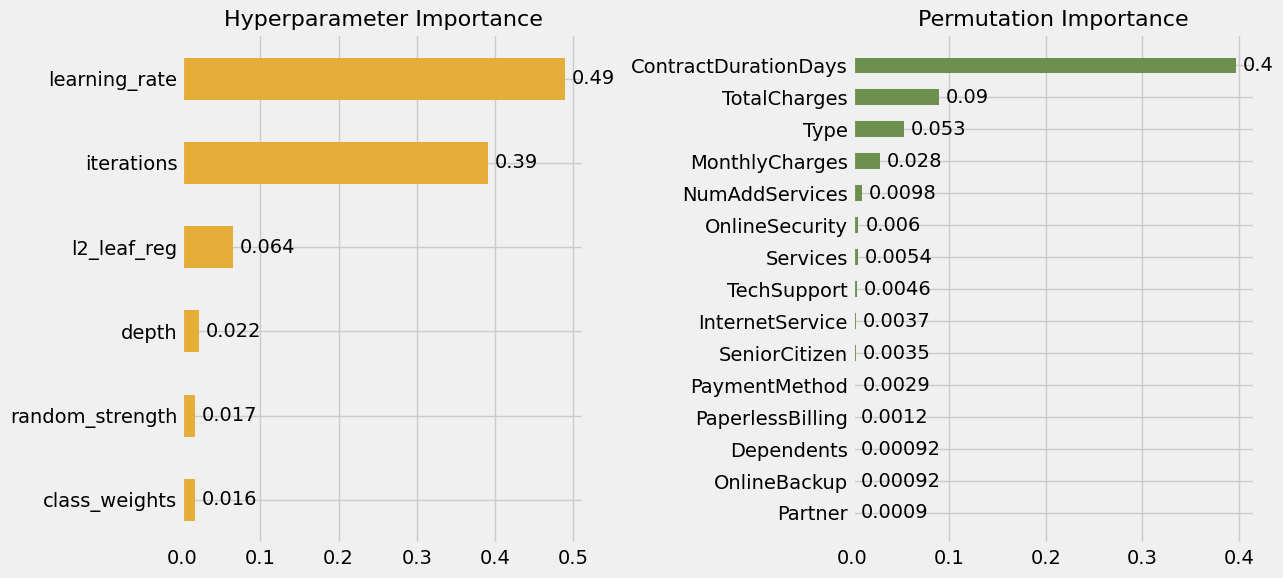

In [60]:
# применение функции plot_param_perm_importances
plot_param_perm_importances(cb_study, cb_model)

- наиболее важные гиперпараметры — `learning rate` и `iterations`;
- наиболее важный признак (с большим отрывом) — `ContractDurationDays`;
- все признаки демонстируют положительные значения, поэтому сохраним все признаки

### XGBClassifier

In [61]:
# создание функции objective для оптимизации гиперпараметров
def objective(trial, scoring):

    # определение пространства поиска значений гиперпараметров    
    params = {'classifier__n_estimators'     : trial.suggest_int('n_estimators', 50, 1000, step = 50),
              'classifier__eta'              : trial.suggest_float('eta', 1e-4, 3e-1, log = True),
              'classifier__max_depth'        : trial.suggest_int('max_depth', 2, 10),
              'classifier__gamma'            : trial.suggest_float('gamma', 1e-3, 1e3, log = True),
              'classifier__min_child_weight' : trial.suggest_float('min_child_weight', 1e-3, 1e3, log = True),
              'classifier__alpha'            : trial.suggest_float('alpha', 1e-3, 1e3, log = True),
              'classifier__lambda'           : trial.suggest_float('lambda', 1e-3, 1e3, log = True),
              'classifier__scale_pos_weight' : trial.suggest_categorical('scale_pos_weight', [1, 73/27]),
              'classifier__colsample_bytree' : trial.suggest_float('colsample_bytree', 0.1, 1.0),
              'classifier__subsample'        : trial.suggest_float('subsample', 0.1, 1.0)}
    
    # обновление гиперпараметров модели    
    xgb_model.set_params(**params)

    # расчет среднего значения auc-roc на обучающей выборке (с кросс-валидацией)                          
    scores = cross_val_score(xgb_model, 
                             features_train, 
                             target_train, 
                             scoring = scoring, 
                             cv      = skf)

    return scores.mean()

In [62]:
model_name = 'XGBClassifier'

# оптимизация гиперпараметров
func = lambda trial: objective(trial, scoring = 'roc_auc')
xgb_study = optuna.create_study(direction = 'maximize', sampler = sampler)
xgb_study.optimize(func, n_trials = 100, show_progress_bar = True)

# расчет среднего значения accuracy на обучающей выборке (с кросс-валидацией) 
# для модели с оптимизированными гиперпараметрами
opt_hparams_accuracy = objective(xgb_study.best_trial, scoring = 'accuracy')

# сохранение результатов оптимизации гиперпараметров
joblib.dump(xgb_study, os.path.join(path, 'xgb_optuna_study.pkl'))
models_data.loc[model_name, 'opt_hparams_roc_auc'] = xgb_study.best_value
models_data.loc[model_name, 'opt_hparams_accuracy'] = opt_hparams_accuracy
models_data.loc[model_name, 'best_params'] = [xgb_study.best_params]

# вывод на экран лучших значений гиперпараметров
print(f'Best params:\n')
for parameter, value in xgb_study.best_params.items():
    print(f'{parameter}: {value}')
print()

# вывод на экран значений auc-roc и accuracy до и после оптимизации гиперпараметров
metrics_to_display = ['baseline_roc_auc', 'opt_hparams_roc_auc', 'baseline_accuracy', 'opt_hparams_accuracy']
models_data.loc[model_name, metrics_to_display].to_frame()

Best params:

n_estimators: 950
eta: 0.18432864834976773
max_depth: 10
gamma: 0.012843025466106127
min_child_weight: 0.009554044032613774
alpha: 0.03597169002730273
lambda: 0.001290217350507387
scale_pos_weight: 2.7037037037037037
colsample_bytree: 0.11460907284597623
subsample: 0.9299281001273272



,XGBClassifier
baseline_roc_auc,0.900859
opt_hparams_roc_auc,0.922442
baseline_accuracy,0.853849
opt_hparams_accuracy,0.870694


- оптимизация гиперпараметров улучшила значения обеих метрик

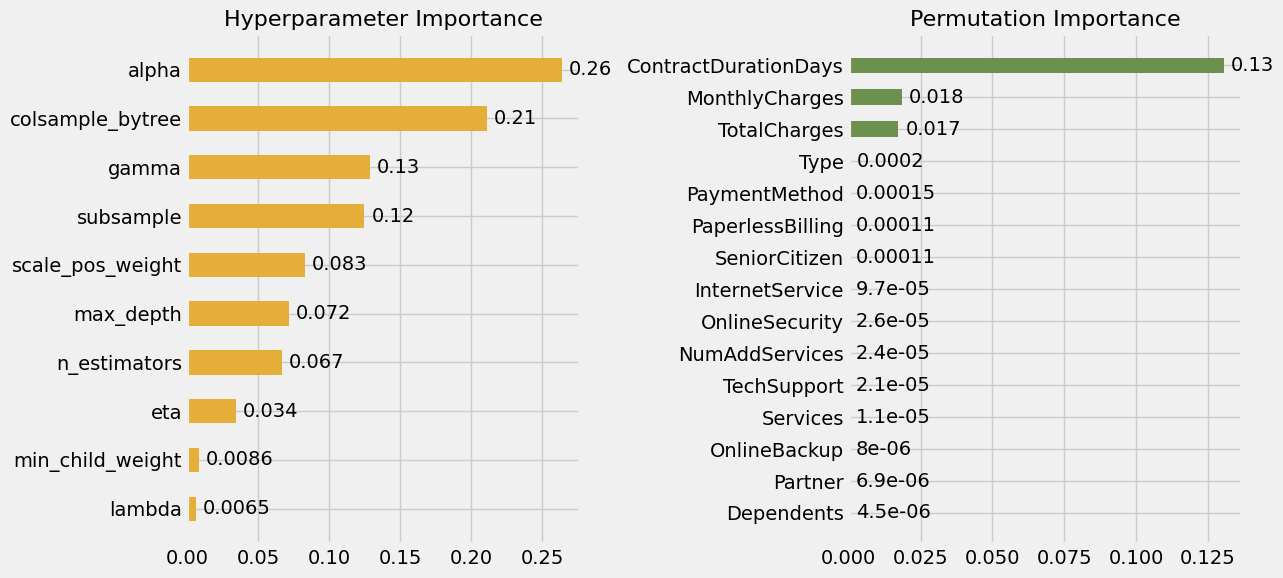

In [63]:
# применение функции plot_param_perm_importances
plot_param_perm_importances(xgb_study, xgb_model)

- наиболее важные гиперпараметры — `alpha` и `colsample_bytree`;
- наиболее важный признак (с большим отрывом) — `ContractDurationDays`;
- все признаки демонстируют положительные значения, поэтому сохраним все признаки

### Сравнение моделей

Сравним значения метрик моделей после оптимизации гиперпараметров:

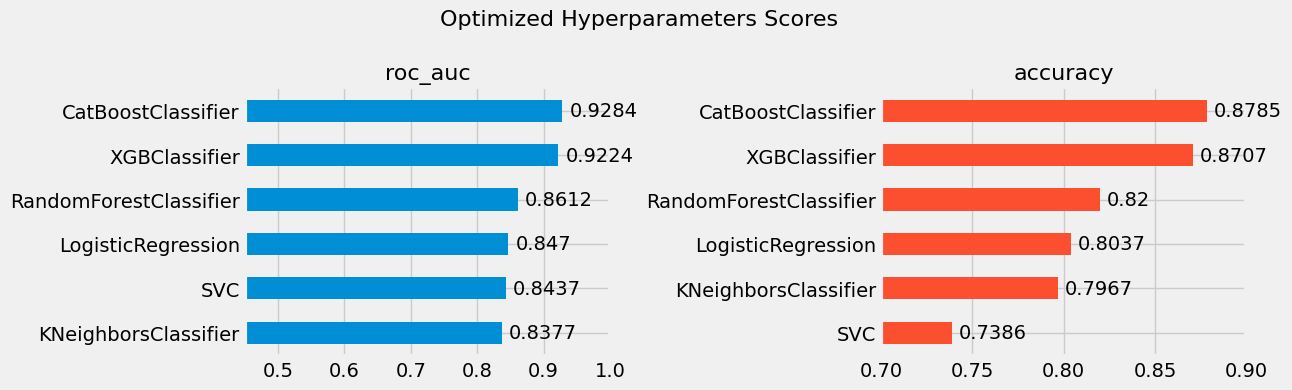

In [64]:
# применение функции plot_scores
plot_scores('opt_hparams', 'Optimized Hyperparameters Scores')

В результате оптимизации гиперпараметров:

- лучшие значения метрик `AUC-ROC` (`0.9284`) и `Accuracy` (`0.8785`) показала модель `CatBoostClassifier` (однако разница между ее результатами и результатами `XGBClassifier` незначительна);
- помимо моделей `CatBoostClassifier` и `XGBClassifier` модель `RandomForestClassifier` также показала значения метрики `AUC-ROC` выше целевого целевого значения `0.85`.

### Ансамбли

Попробуем увеличить значение метрики `AUC-ROC`, составив ансамбли из обученных моделей:

In [65]:
# создание списка с моделями и их названиями
estimators = [('LogisticRegression', lr_model),
              ('SVC', lr_model),
              ('RandomForestClassifier', rf_model),
              ('KNeighborsClassifier', knn_model),
              ('CatBoostClassifier', cb_model),
              ('XGBClassifier', xgb_model)]

In [66]:
# создание ансамблевых моделей
stacking_model = StackingClassifier(estimators = estimators,
                                    cv         = skf)

voting_model = VotingClassifier(estimators = estimators,
                                voting     = 'soft')

In [67]:
# добавление модели StackingClassifier и VotingClassifier и их названий в списки models и models_names
models.extend([stacking_model, voting_model])
models_names.extend(['StackingClassifier', 'VotingClassifier'])

### Выводы

На данном этапе мы обучили шесть моделей:
- `LogisticRegression`;
- `SVC`;
- `RandomForestClassifier`;
- `KNeighborsClassifier`;
- `CatBoostClassifier`; и
- `XGBClassifier`,

а также константную модель `DummyClassifier`, предсказывающую самый популярный класс.

Для каждой из моделей (за исключением константной)  мы оптимизировали гиперпараметры.

В результате оптимизации гиперпараметров:

- лучшие значения метрик `AUC-ROC` и `Accuracy` показала модель `CatBoostClassifier` (однако разница между ее результатами и результатами `XGBClassifier` незначительна);
- три модели (`CatBoostClassifier`, `XGBClassifier` и `RandomForestClassifier`) показали значения метрики `AUC-ROC` выше целевого целевого значения `0.85`.

Мы также составили из моделей с оптимизированными гиперпараметрами две ансамблевых модели: `StackingClassifier` и `VotingClassifier`.

Теперь мы можем перейти к тестированию моделей.

## Тестирование моделей

Протестируем модели на тестовой выборке:

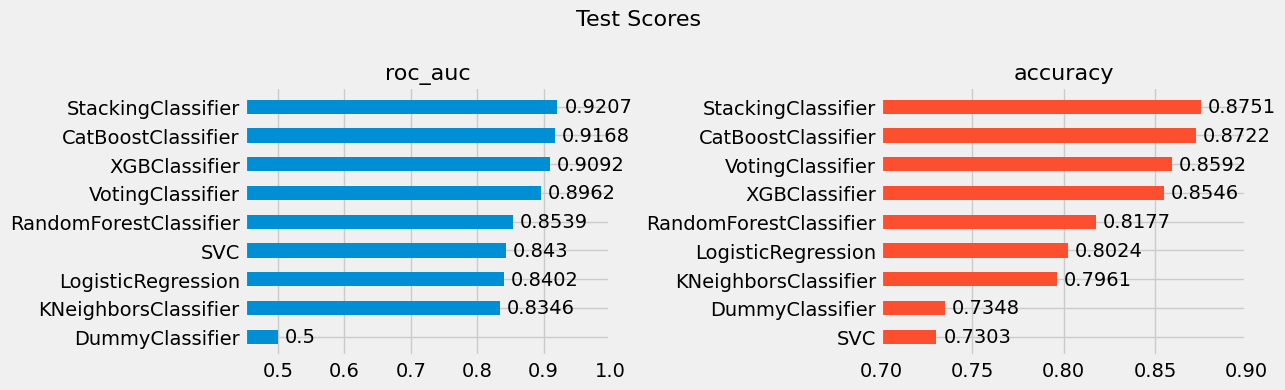

In [68]:
# для каждой модели
for model_name, model in zip(models_names, models):

    # обучение на тестовой выборке
    model.fit(features_train, target_train)

    # получение и сохранение значений AUC-ROC и accuracy на тестовой выборке
    models_data.loc[model_name, 'test_roc_auc'] = roc_auc_score(target_test, model.predict_proba(features_test)[:, 1])
    models_data.loc[model_name, 'test_accuracy'] = accuracy_score(target_test, model.predict(features_test))

# применение функции plot_scores
plot_scores('test', 'Test Scores')

На тестовой выборке:

- лучшие значения метрик `AUC-ROC` (`0.9207`) и `Accuracy` (`0.8751`) показала модель `StackingClassifier`;
- пять моделей (`StackingClassifier`, `VotingClassifier`, `CatBoostClassifier`, `XGBClassifier` и `RandomForestClassifier`) показали значения метрики `AUC-ROC` выше целевого целевого значения `0.85`.

Изучим матрицы ошибок моделей:

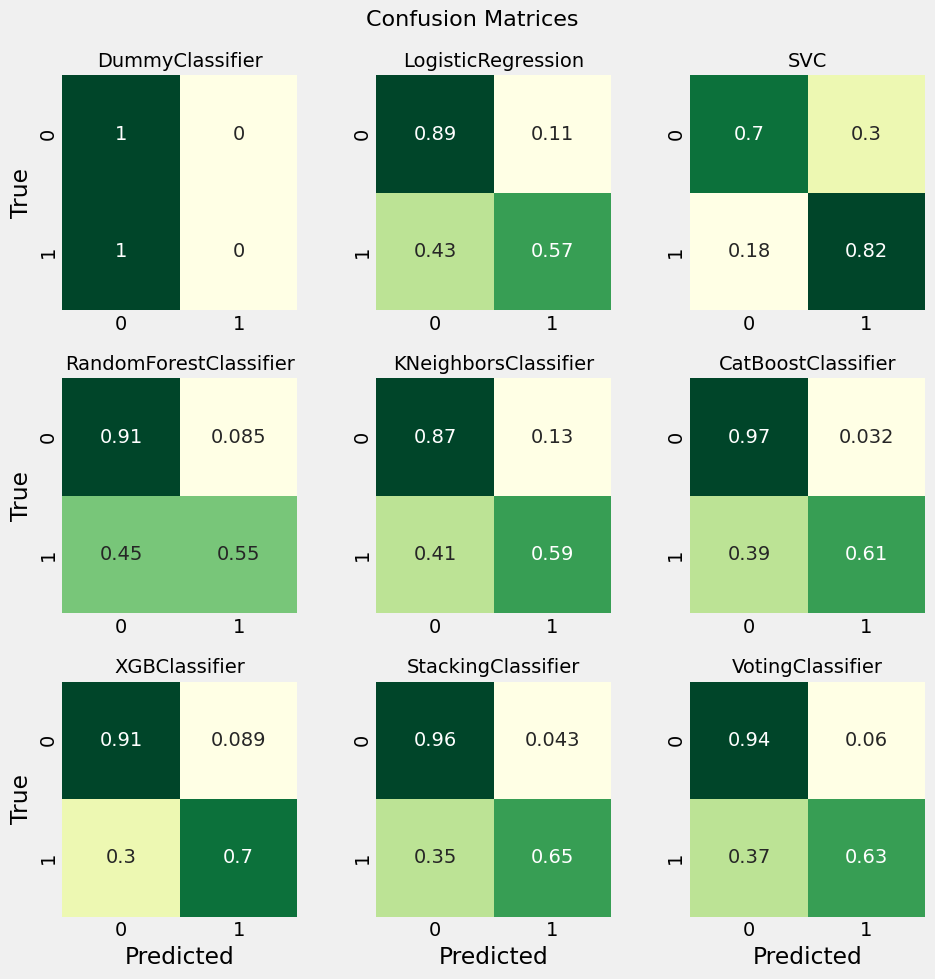

In [69]:
# вывод на экран матриц ошибок моделй
fig, ax = plt.subplots(nrows   = 3, 
                       ncols   = 3,
                       figsize = (10, 10))

ax = ax.flatten()

for i, (model, model_name) in enumerate(zip(models, models_names)):
    cm = confusion_matrix(target_test, 
                          model.predict(features_test), 
                          normalize = 'true')
    
    sns.heatmap(data   = cm,
                cmap   = plt.colormaps['YlGn'].resampled(7),
                annot  = True,
                square = True,
                cbar   = False,
                ax     = ax[i])
    
    ax[i].set_title(model_name, fontsize = 14)
    if i > 5:
        ax[i].set_xlabel('Predicted')
    if i in (0, 3, 6):
        ax[i].set_ylabel('True')

fig.suptitle('Confusion Matrices', fontsize = 16)

plt.tight_layout()
plt.show()

- наиболее точно предсказывет целевой класс модель `CatBoostClassifier`;
- наиболее полно предсказывет целевой класс модель `SVM` (а среди моделей, показавших значение `AUC-ROC` выше целевого значения — `XGBClassifier`);
- лучшая модель по метрике `AUC-ROC` (`StackingClassifier`) с большей вероятностью ошибочно классифицирует «уходящего» клиента как текущего.


### Выводы

На данном этапе мы протестировали модели на тестовой выборке:

- лучшие значения метрик `AUC-ROC` (`0.9207`) и `Accuracy` (`0.8751`) показала модель `StackingClassifier`;
- пять моделей (`StackingClassifier`, `VotingClassifier`, `CatBoostClassifier`, `XGBClassifier` и `RandomForestClassifier`) показали значения метрики `AUC-ROC` выше целевого целевого значения `0.85`;
- наиболее точно предсказывет целевой класс модель `CatBoostClassifier`;
- наиболее полно предсказывет целевой класс модель `SVM` (а среди моделей, показавших значение `AUC-ROC` выше целевого значения — `XGBClassifier`);
- лучшая модель по метрике `AUC-ROC` (`StackingClassifier`) с большей вероятностью ошибочно классифицирует «уходящего» клиента как текущего.

Если заказчику необходимо максимизировать метрики `AUC-ROC` и `Accuracy`, мы рекоммендуем модель `StackingClassifier` как лучшую по обеим метрикам (`0.9207` и `0.8751` соответственно).

Если же заказчику достаточно, чтобы модель демонстрировала значение метрики  `AUC-ROC` не ниже `0.85`, то в зависимости от того, важнее ли заказчику точность или полнота, мы рекоммендуем `CatBoostClassifier` или `XGBClassifier`.

## Общие выводы

**Введение**

*Задача*

Перед нами была поставлена задача построить для оператора связи модель, которая будет классифицировать клиентов в качестве «уходящих» и демонстировать качество прогноза `AUC-ROC` не ниже 0.85. Дополнительная метрика — `Accuracy`.

На основе предсказаний модели планируется предлагать таким «уходящим» клиентам промокоды и специальные условия.

*Предоставленные данные*

Полученные из разных источников персональные данные о некоторых клиентах и информация об их тарифах и договорах в форме четырех файлов:

- `contract.csv` — информация о клиентских договорах (актуальна на 1 февраля 2020 года);
- `personal.csv` — персональные данные клиентов;
- `internet.csv` — информация об оказываемых клиентам интернет-услугах;
- `phone.csv` — информация об оказываемых клиентам услугах телефонии.

Во всех файлах столбец `customerID` содержит уникальный код клиента.

*Основные этапы работы*

Работа над задачей включала шесть основных этапов:

1. загрузка и первичное изучение данных;
2. подготовка данных для исследовательского анализа;
3. исследовательский анализ данных;
4. подготовка к обучению моделей;
5. обучение моделей; и
6. тестирование моделей.

**Загрузка и первичное изучение данных**

На данном этапе мы загрузили данные и провели их первичное изучение.

По его итогам мы установили:

*Общие выводы*

- датасеты `contract` и `personal` содержат 7043 объекта, датасеты `internet` и `phone` — 5517 и 6361 объект соответственно;
- не все клиенты одновременно пользуются интернет-услугами и услугами телефонии;
- датасеты не содержат явных пропусков и дубликатов;
- датасеты содержат информацию об одних и тех же клиентах;
- датасеты содержат 19 признаков (без учета признака `customerID`), включая:
    - 2 числовых;
    - 16 категориальных;
    - 1 календарный.

*Предобработка данных*

Необходимо/целесообразно:

- объединить датасеты;
- создать целевой признак `Churn` на основе признака `EndDate` датасета `contract`;
- устранить неявные пропуски в значениях признака `TotalCharges` датасета `contract` (заполнив их значениями признака `MonthlyCharges`);
- изменить типы данных признаков: 
    - `BeginDate` и `EndDate` датасета `contract` на `datetime`;
    - `TotalCharges` датасета `contract` на `float`.

**Подготовка данных для исследовательского анализа**

В ходе подготовки данных для исследовательского анализа мы:

- объединили датасеты;
- изменили типы данных признаков:

    - `TotalCharge` — на `float`;
    - `BeginDate` и `EndDate` — на `datetime`;
    
- заполнили пропуски в значениях:

    - признака `EndDate` — значением `'2020-02-01 00:00:00'` (последней датой, на которую доступны данные о клиентских договорах);
    - признака `TotalCharges` — значениями признака `MonthlyCharges`;
    - признака `InternetService` — значением `not using internet`;
    - остальных признаков — значением `False`;

- создали следующие новые признаки:

    - `Services` — услуги, которыми пользуется клиент (услуги телефонии, интернет-услуги или все вместе);
    - `Churn` — продолжает ли клиент пользоваться услугами оператора (целевой признак);
    - `ContractDurationDays` — количество дней пользования услугами;
    - `NumAddServices` — количество дополнительных услуг, котормыми пользуется клиент.

Теперь мы можем приступить к исследовательскому анализу данных.

**Исследовательский анализ данных**

В ходе исследовательского анализа мы:

- проанализировали соотношение классов;
- сравнили классы по различным признакам;
- изучили корреляцию признаков.

*Соотношение классов*

Классы несбалансированы — ушедшие пользователи составляют чуть больше четверти всей выборки.

Основаня целевая метрика — AUC-ROC — не чувствительна к дисбалансу классов, дополнительная — Accuracy — чувствительна, поэтому во время тестирования моделей стоит дополнительно изучить матрицы ошибок моделей.

*Сравнение классов по различным признакам*

<u>Персональные данные</u>

Среди ушедших клиентов:

- вдвое больше пенсионеров (25% против 13%); 
- на треть меньше имеющих партнеров (36% против 53%);
- вдвое меньше имеющих иждивенцев (17% против 34%).

В обоих классах примерно одинаковое разделение по полу (данный признак может быть малоинформативен).

<u>Используемые услуги</u>

Среди ушедших клиентов:

- на треть больше одновременно пользующихся услугами телефонии и интернет-услугами (85% против 63%); 
- значительно меньше пользующихся только услугами телефонии (6% против 27%).
- больше всего пользующихся одной дополнительной услугой (среди текущих клиентов большинство не пользуется дополнительными услугами).

В обоих классах одинаковые Топ-5 используемых дополнительных услуг.

<u>Услуги телефонии</u>

В обоих классах примерно у половины клиентов, пользующихся услугами телефонии, подключена дополнительная услуга `MultipleLines` (данный признак может быть малоинформативен).

<u>Интернет-услуги</u>

Среди ушедших клиентов:
- вдове меньше использующих тип подключения `'DSL'` (26% против 52%);
- меньше доля пользующихся дополнительными услугами `OnlineSecurity`, `OnlineBackup`, `DeviceProtection` и `TechSupport`.

В обоих классах примерно половина клиентов пользуется дополнительными услугами `StreamingTV` и `StreamingMovies` (данные признаки могут быть малоинформативны).

<u>Оплата услуг и период пользования услугами</u>

Ушедшие клиенты:

- вдвое чаще предпочитают ежемесячную оплату услуг (89% против 43%) и получение счетов на оплату услуг по электронной почте (57% против 25%);
- чаще пользуются возможностью получения электронного чека (75% против 54%).

Среди ушедших клиентов:

- выше месячный средний чек (74 против 61) (что может объясняться более активным использованием дополнительных услуг) 
- в четыре раза меньше среднее количество дней пользования услугами (304 дня против 1157 дней).

*Корреляция*

<u>Корреляция Пирсона</u>

Наблюдаются ожидаемые:

- заметная положительная корреляция между признаками `MonthlyCharges` и `TotalCharges`;
- высокая положительная корреляция между признаками `ContractDurationDays` и `TotalCharges`.

<u>Корреляция Phik</u>

- наибольшую корреляцию с целевым признаком `Churn` демонстрируют признаки: 
    - `ContractDurationDays` (0.47);
    - `PaymentMethod` (0.45);
    - `MonthlyCharges` (0.36); и
    - `PaperlessBilling` (0.30);
- наименьшую корреляцию с целевым признаком `Churn` демонстрируют признаки: 
    - `gender` (0);
    - `MultipleLines` (0.06);
    - `StreamingMovies` (0.09);
    - `StreamingTV` (0.10); и
    - `DeviceProtection` (0.10);
- признаки `Services` и `InternetService` и `Services` и `MonthlyCharges` демонстируют мультиколлинеарность;
- признак `gender` демонстрирует низкую корреляцию с другими признаками;
- признаки, демонстрирующие высокую корреляцию с целевым признаком, также демонстрирую высокую статистическую значимость; признаки, демонстрирующие низкую корреляцию с целевым признаком - низкую статистическую значимость.

**Подготовка к обучению моделей**

На этапе подготовки к обучению моделей мы:

- отобрали 15 признаков для обучения:
    - `Type`;
    - `PaperlessBilling`; 
    - `PaymentMethod`;
    - `MonthlyCharges`;
    - `TotalCharges`;
    - `SeniorCitizen`;
    - `Partner`;
    - `Dependents`;
    - `InternetService`; 
    - `OnlineSecurity`; 
    - `OnlineBackup`;
    - `TechSupport`;
    - `Services`;
    - `ContractDurationDays`;
    - `NumAddServices`;
- разделили данные на обучающую и тестовую выборки;
- создали пайплайны для препроцессинга признаков.

В состав признаков для обучения не вошли следующие признаки:

- `BeginDate`, `EndDate`  - данные признаки использовались только для создания новых признаков;
- `gender`, `DeviceProtection`, `StreamingTV`, `StreamingMovies`, `MultipleLines` - признаки демостритуют низкую корреляцию с целевым признаком и низкую статистическую значимость корреляции.

Сокращение количества признаков также повысит скорость обучения моделей.

**Обучение моделей**

На данном этапе мы обучили шесть моделей:

- `LogisticRegression`;
- `SVC`;
- `RandomForestClassifier`;
- `KNeighborsClassifier`;
- `CatBoostClassifier`; и
- `XGBClassifier`,

а также константную модель `DummyClassifier`, предсказывающую самый популярный класс.

Для каждой из моделей (за исключением константной)  мы оптимизировали гиперпараметры.

В результате оптимизации гиперпараметров:

- лучшие значения метрик `AUC-ROC` и `Accuracy` показала модель `CatBoostClassifier` (однако разница между ее результатами и результатами `XGBClassifier` незначительна);
- три модели (`CatBoostClassifier`, `XGBClassifier` и `RandomForestClassifier`) показали значения метрики `AUC-ROC` выше целевого целевого значения `0.85`.

Мы также составили из моделей с оптимизированными гиперпараметрами две ансамблевых модели: `StackingClassifier` и `VotingClassifier`.

**Тестирование моделей**

На данном этапе мы протестировали модели на тестовой выборке:

- лучшие значения метрик `AUC-ROC` (`0.9207`) и `Accuracy` (`0.8751`) показала модель `StackingClassifier`;
- пять моделей (`StackingClassifier`, `VotingClassifier`, `CatBoostClassifier`, `XGBClassifier` и `RandomForestClassifier`) показали значения метрики `AUC-ROC` выше целевого целевого значения `0.85`;
- наиболее точно предсказывет целевой класс модель `CatBoostClassifier`;
- наиболее полно предсказывет целевой класс модель `SVM` (а среди моделей, показавших значение `AUC-ROC` выше целевого значения — `XGBClassifier`);
- лучшая модель по метрике `AUC-ROC` (`StackingClassifier`) с большей вероятностью ошибочно классифицирует «уходящего» клиента как текущего.

Если заказчику необходимо максимизировать метрики `AUC-ROC` и `Accuracy`, мы рекоммендуем модель `StackingClassifier` как лучшую по обеим метрикам (`0.9207` и `0.8751` соответственно).

Если же заказчику достаточно, чтобы модель демонстрировала значение метрики  `AUC-ROC` не ниже `0.85`, то в зависимости от того, важнее ли заказчику точность или полнота, мы рекоммендуем `CatBoostClassifier` или `XGBClassifier`.